## **Imports**

In [55]:
!pip install transformers
!pip install optuna
!pip install wandb
!pip install evaluate

In [56]:
!pip install huggingface_hub

In [57]:
# Relevant imports:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
import shutil
from google.colab import files

import os
import json
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
from torch import nn, optim
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback, get_scheduler
from torch.nn.utils import prune

import optuna
import wandb
from datasets import Dataset, DatasetDict, load_from_disk, Value, Sequence, concatenate_datasets

from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Part A - Exploratory Data Analysis (EDA)**

#### Data Path (Relevant for running the files not from Drive) - **PLEASE FIRST DOWNLOAD THE [Project_COVID_NLP folder](https://drive.google.com/drive/folders/1egGGJ6F878xIk_bKUfjhyZStESiliwRC?usp=sharing) accessible from idankanat@gmail.com's Google drive!!**

In [59]:
# Basic Drive path we used for this project. Assuming Google Colab exists as well as mounting files to drive, user can change it accordingly as he downloads the Project_COVID_NLP folder as specified in the project_root below and documented above.
basic_drive_path = "/content/drive/MyDrive" # USER CAN CHANGE IT IF HE DOESN'T WORK IN DRIVE AND DOWNLOADS FROM DRIVE THE Project_COVID_NLP folder!!
project_root = f"{basic_drive_path}/Project_COVID_NLP" # Root project folder
data_path = f"{project_root}/data"

In [60]:
# Loading the Corona_NLP_train dataset:
df = pd.read_csv(f"{data_path}/Corona_NLP_train.csv", encoding='latin1')
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,6420,51372,17,17-03-2020,i dont even know if its possible but i really ...,Negative
1,30922,75874,205,3/4/2020,I have an online shopping problem and the fact...,Positive
2,23519,68471,234,24-03-2020,Consumer protection agency warns traders infla...,Negative
3,13442,58394,401,20-03-2020,Day 1 of lockdown complete. IÂm broke as a jo...,Negative
4,12665,57617,406,20-03-2020,If your local friendly corner shop is sellin...,Positive
5,5106,50058,501,17-03-2020,"If weÂre gonna be stuck inside for awhile, IÂ...",Negative
6,20656,65608,704,23-03-2020,Senior shopping hours Every Monday amp Thursda...,Negative
7,5956,50908,765,17-03-2020,So I canÂt go get no food?,Negative
8,35509,80461,918,7/4/2020,1 Hello all My company has started to manufact...,Extremely Positive
9,4588,49540,954,17-03-2020,@HaileeSteinfeld IÂm good. Trying to keep mys...,Extremely Positive


In [61]:
wandb.login()

True

### **Sentiments Distribution**

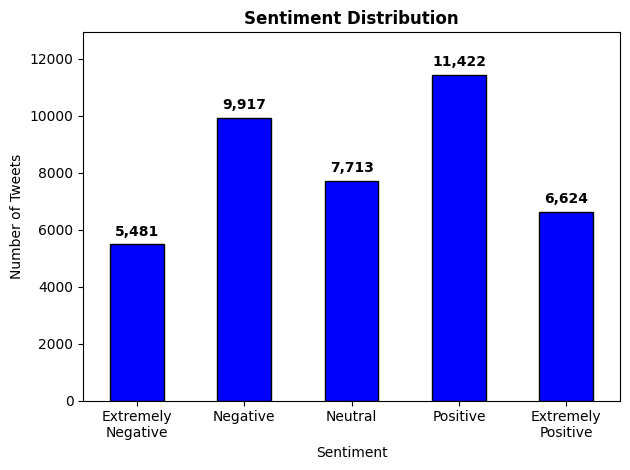

In [62]:
# Count sentiment frequencies
sentiment_counts = df['Sentiment'].value_counts()

# Define the custom order
custom_order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

# Reindex according to desired order
sentiment_counts = sentiment_counts.reindex(custom_order)

# Format long labels to be multi-line
sentiment_counts.index = sentiment_counts.index.str.replace("Extremely Positive", "Extremely\nPositive")
sentiment_counts.index = sentiment_counts.index.str.replace("Extremely Negative", "Extremely\nNegative")

# Plotting the general sentiment distribution
ax = sentiment_counts.plot(kind='bar', color='blue', edgecolor='black')

# Add title and labels
plt.title("Sentiment Distribution", fontweight='bold')
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)

# Add top margin so numbers don't touch the edge
plt.ylim(0, sentiment_counts.max() + 1500)

# Add bold value labels for each sentiment category, with comma formatting
for i, count in enumerate(sentiment_counts):
    if pd.notna(count):
        plt.text(i, count + 200, f"{int(count):,}", ha='center', va='bottom', fontsize=10, fontweight = "bold")

# Show the plot
plt.tight_layout()
plt.show()

From the sentiment distribution shown above, we can draw a few conclusions:
1. **There are more positive tweets than negative tweets.**
2. **There are more extremely positive tweets than extremely negative tweets.** This ensures that even when combining the extremes of each sentiment, positive tweets outnumber negatives. The gap between positive and negative tweets enlarges as we add the extremes of each group.

### **Daily Tweet Counts**

/tmp/ipython-input-1018288224.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'], dayfirst=False, errors='coerce')


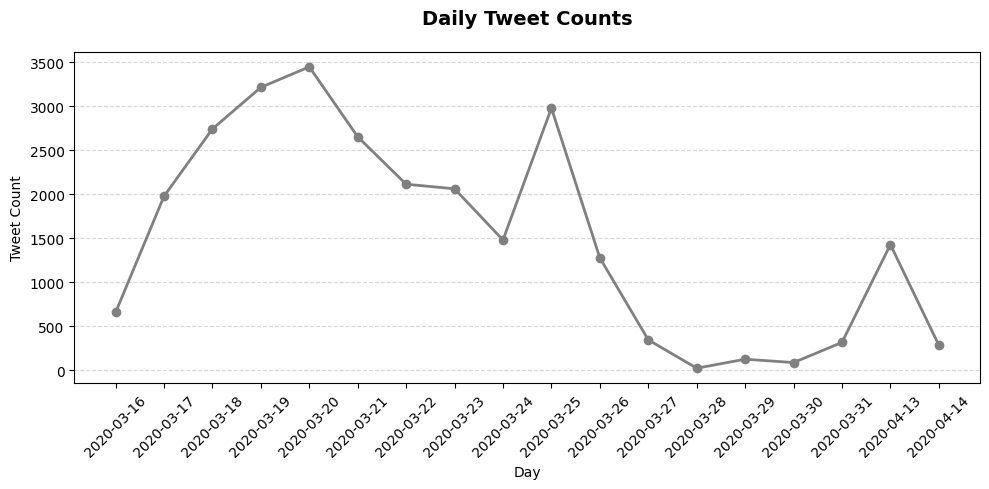

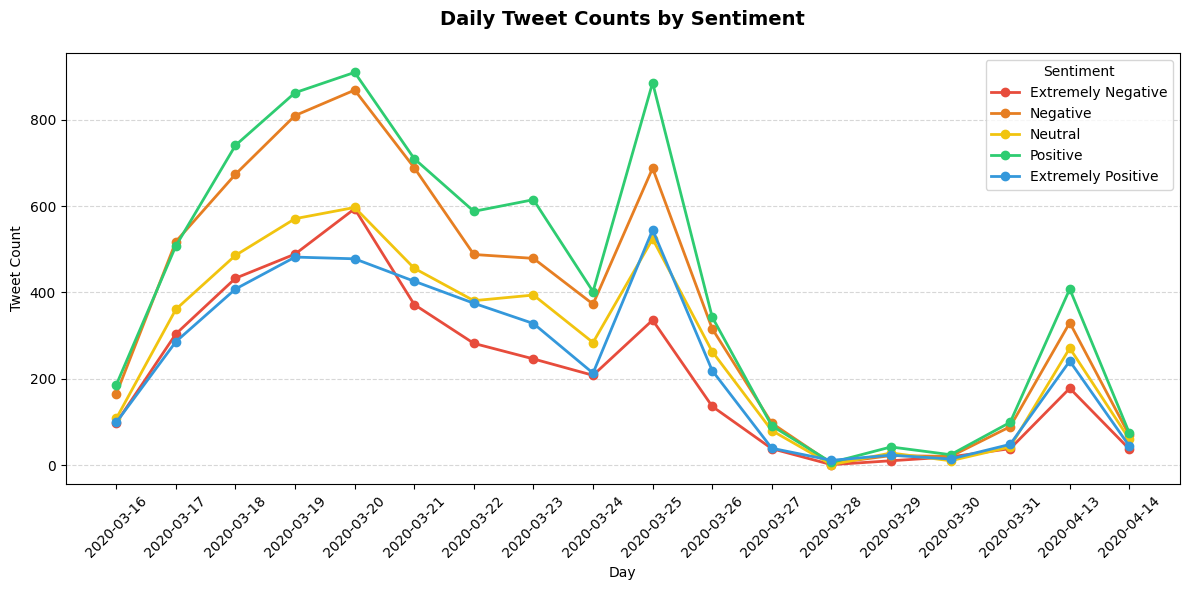

In [63]:
# Standardize the 'TweetAt' date column:
df['TweetAt'] = pd.to_datetime(df['TweetAt'], dayfirst=False, errors='coerce')
df = df.dropna(subset=['TweetAt'])

# Create a new column 'YearMonth' for grouping by month
df['YearDay'] = df['TweetAt'].dt.date

# Add a column for tweet length:
df['TweetLength'] = df['OriginalTweet'].astype(str).apply(len)

# Define sentiment colors:
sentiment_order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
colors = {
    'Extremely Negative': '#e74c3c',
    'Negative': '#e67e22',
    'Neutral': '#f1c40f',
    'Positive': '#2ecc71',
    'Extremely Positive': '#3498db',
    'All Tweets': 'gray'
}

# First, plotting all tweets:
fig, ax = plt.subplots(figsize=(10, 5))
day_counts_all = df.groupby('YearDay').size()
x_all = day_counts_all.index.astype(str)
y_all = day_counts_all.values
ax.plot(x_all, y_all, color='gray', marker='o', linewidth=2)
ax.set_title("Daily Tweet Counts", fontweight='bold', fontsize=14, pad=20)
ax.set_xlabel("Day")
ax.set_ylabel("Tweet Count")
ax.tick_params(axis='x', rotation=45)
# for spine in ax.spines.values():
    # spine.set_edgecolor('red')
    # spine.set_linewidth(3)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Second, plotting stratified sentiment trends in one plot:
fig, ax = plt.subplots(figsize=(12, 6))

for sentiment in sentiment_order:
    data = df[df['Sentiment'] == sentiment]
    day_counts = data.groupby('YearDay').size()
    x = day_counts.index.astype(str)
    y = day_counts.values
    ax.plot(x, y, label=sentiment, color=colors[sentiment], marker='o', linewidth=2)

ax.set_title("Daily Tweet Counts by Sentiment", fontweight='bold', fontsize=14, pad=20)
ax.set_xlabel("Day")
ax.set_ylabel("Tweet Count")
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(title="Sentiment")
plt.tight_layout()
plt.show()

From the two plots above, we can conclude:
- As we could intuitively predict, there was a surge of tweets in March 2020 following the COVID-19 outburst.
- This massive surge in tweets wasn't attributed to any specific sentiment but rather all different sentiments indicated much more frequent tweets in March.

### **Tweet Length Distribution**

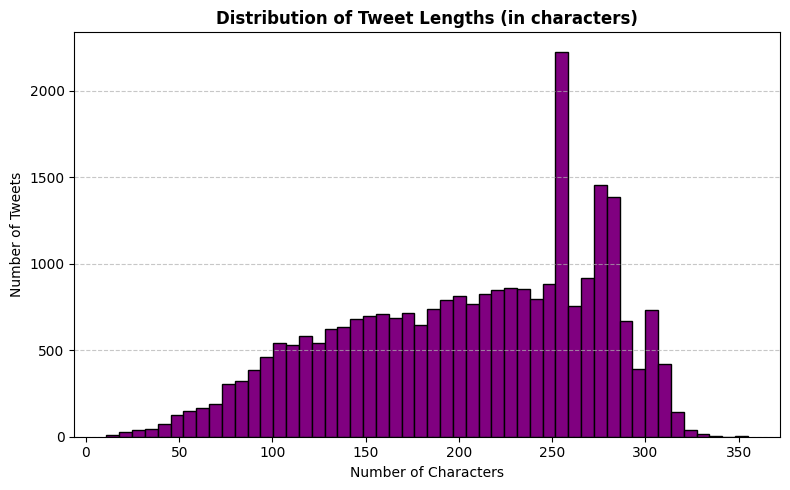

In [64]:
# Compute the number of characters in each tweet
df['TweetLength'] = df['OriginalTweet'].astype(str).str.len()

# Plotting a histogram of tweet lengths:
plt.figure(figsize=(8, 5))
plt.hist(df['TweetLength'], bins=50, color='purple', edgecolor='black')

plt.title("Distribution of Tweet Lengths (in characters)", fontweight='bold')
plt.xlabel("Number of Characters")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [65]:
# Displaying summary statistics using the .describe() command:
length_stats = df['TweetLength'].describe().astype(int)
length_stats

,TweetLength
count,27211
mean,205
std,68
min,11
25%,152
50%,216
75%,260
max,355


From the tweet length distributions, several conclusions can be drawn:
- **Strong right skew up to the character limit -** There’s a visible increase in tweet counts as length increases, peaking around 240–280 characters.

- **A sharp drop after ~280 characters -** Reflects the Twitter character limit (likely 280) — tweets can't go longer, so the distribution is naturally cut off there.

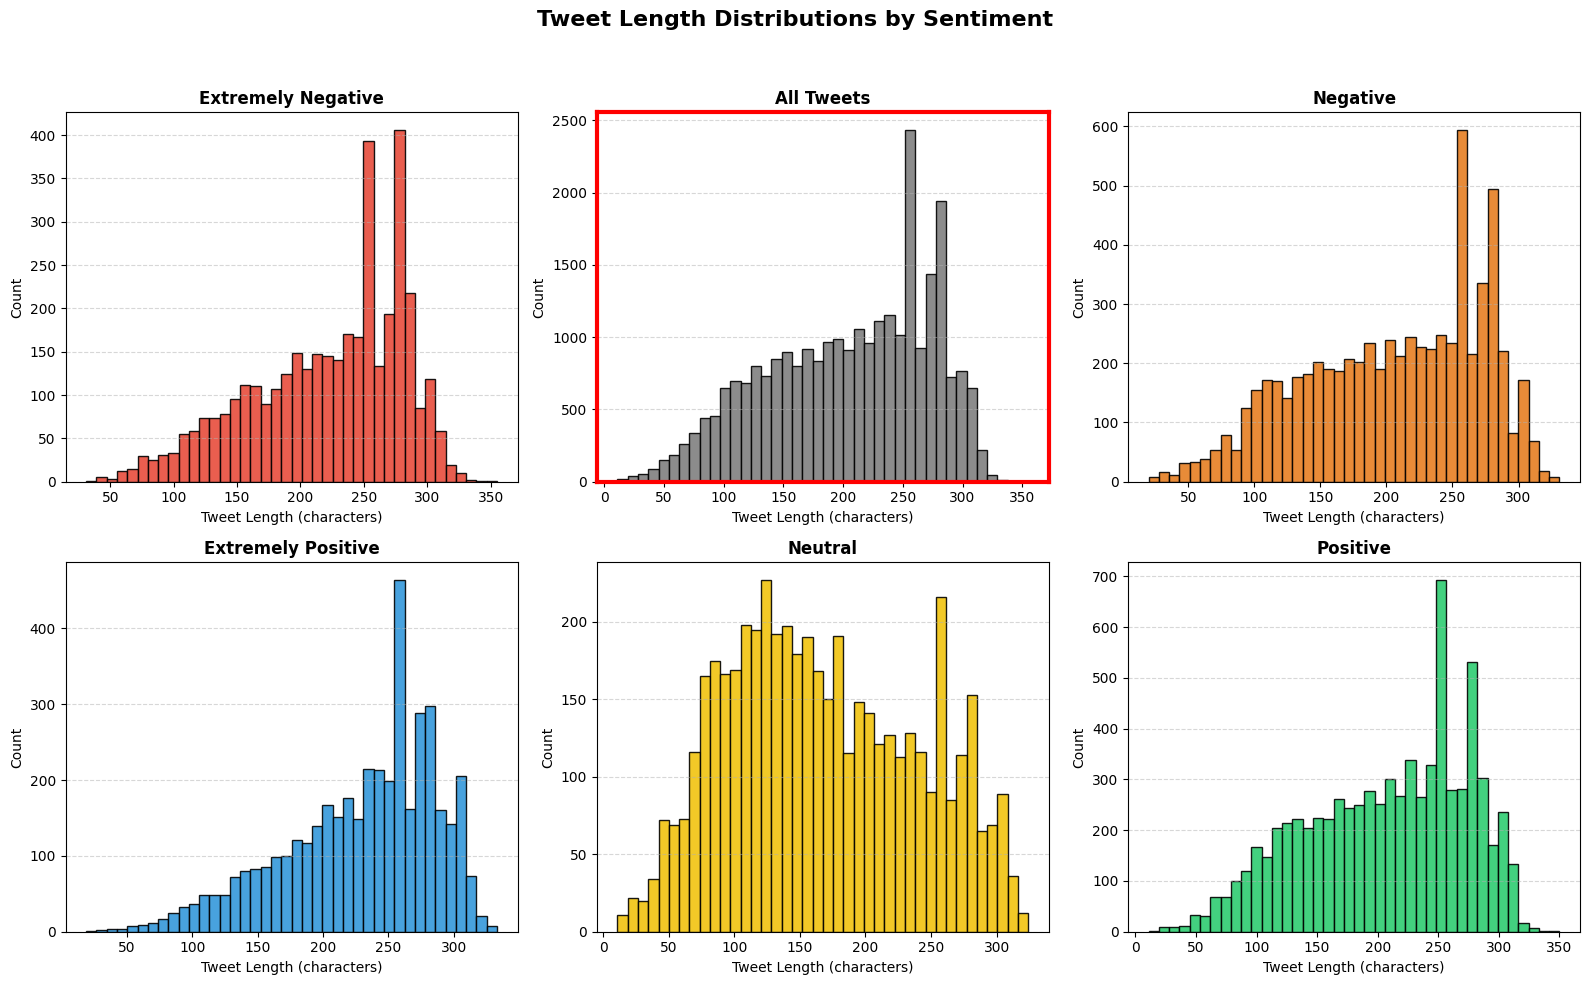

In [66]:
from matplotlib.patches import Rectangle

# Sentiment labels and colors
sentiment_order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
colors = {
    'Extremely Negative': '#e74c3c',
    'Negative': '#e67e22',
    'Neutral': '#f1c40f',
    'Positive': '#2ecc71',
    'Extremely Positive': '#3498db',
    'All Tweets': 'gray'
}

# Manual plot order with 'All Tweets' in the center
plot_order = [
    'Extremely Negative', 'All Tweets', 'Negative',
    'Extremely Positive',            'Neutral',   'Positive'
]

# Create 2x3 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
axes = axes.flatten()

# Plot each distribution
for i, label in enumerate(plot_order):
    if label == 'All Tweets':
        data = df['TweetLength']
    else:
        data = df[df['Sentiment'] == label]['TweetLength']

    axes[i].hist(data, bins=40, color=colors[label], edgecolor='black', alpha=0.9)
    axes[i].set_title(label, fontweight='bold')
    axes[i].set_xlabel("Tweet Length (characters)")
    axes[i].set_ylabel("Count")
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Add bold border to the axes itself (cleaner than external patch)
    if label == 'All Tweets':
        for spine in axes[i].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)


# Title and layout
plt.suptitle("Tweet Length Distributions by Sentiment", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Comapring the stratified distribution charts above to the general tweet-length distribution, a few insights emerge:
1. The distributions of EACH of the non-neutral sentiments (i.e. both positive, negative, and extreme sentiments) seems to ***largely*** align with the general tweet length distribution - right skewed - i.e. a tail to the left. Long tweets are frequent.
2. The only distinctfully different stratified histogram is w.r.t to the ***neutral*** sentiment, where shorter tweet lengths are also common, as well as the longer tweets (which are frequent in the other histograms too).

In [67]:
# Ensure tweet lengths are computed
df['TweetLength'] = df['OriginalTweet'].astype(str).str.len()

# Define sentiment order + 'All'
all_labels = sentiment_order + ['All Tweets']

# Initialize dictionary to collect describe stats
summary_dict = {}

# Add describe() for each sentiment
for sentiment in sentiment_order:
    stats = df[df['Sentiment'] == sentiment]['TweetLength'].describe().astype(int)
    summary_dict[sentiment] = stats

# Add general (all tweets) stats
summary_dict['All Tweets'] = df['TweetLength'].describe().astype(int)

# Combine into a DataFrame
summary_df = pd.DataFrame(summary_dict)

# Optional: Reorder rows (metrics)
summary_df = summary_df.reindex(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])

# Highlight function
def highlight_extremes(row):
    is_max = row == row.max()
    is_min = row == row.min()
    return ['background-color: lightgreen' if v else
            'background-color: salmon' if m else '' for v, m in zip(is_max, is_min)]

# Styling the dataframe w.r.t to row's maximum (green) & minimum (red)
styled_df = summary_df.style.apply(highlight_extremes, axis=1)

styled_df

,Extremely Negative,Negative,Neutral,Positive,Extremely Positive,All Tweets
count,3819,6700,4917,7496,4279,27211
mean,222,205,167,207,228,205
std,59,66,71,66,57,68
min,31,20,11,11,19,11
25%,181,153,110,157,193,152
50%,237,215,159,218,242,216
75%,272,259,226,259,275,260
max,355,331,324,350,333,355


This table displays the key statistics of each of the stratified distributions (w.r.t to sentiment), as well as the general tweet length distribution. We can observe:

- The longest tweet belongs to the extremely negative sentiment group (355 tokens!), the longest extremely positive tweet consisted of 338 tokens, indicating that tweets invoking extreme emotions appear to be longer and they're potentially POSITIVELY associated with length.
- The neutral sentiment distribution has the largest S.D, aligning with bigger spread than the other distributions, as described above in the graphs.

### **Tweets by Region**

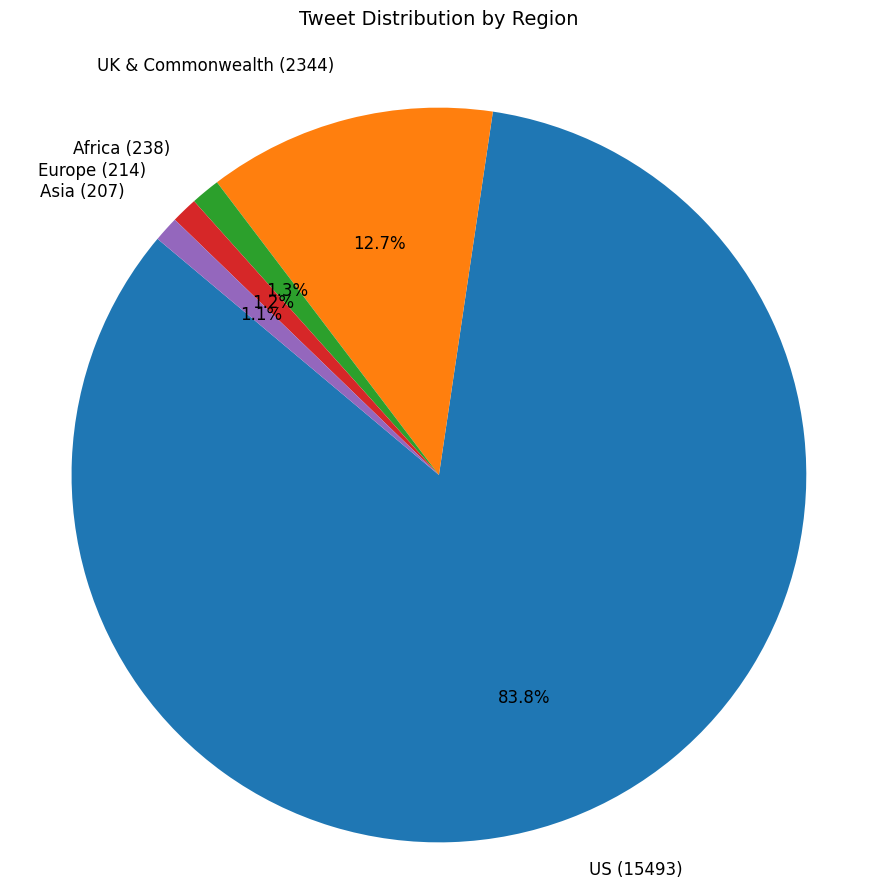

In [68]:
# Load the location data
df['Location'] = df['Location'].fillna("").str.lower()  # Standardize by lowercasing all location values

# Group key-words by region:
region_keywords = {
    "US": [
        "usa", "u.s.a", "u.s", "america", "united states of america", "united states", "texas", "tx", "austin",
        "houston", "abilene", "new york", "new york city", "nyc", "ny", "california", "ca", "florida", "fl",
        "washington", "dc", "washington dc", "washington d.c.", "alaska", "chicago", "illinois", "arizona", "az",
        "atlanta", "ga", "baltimore", "boston", "brooklyn", "manhattan", "queens", "bronx", "staten island",
        "il", "nc", "nj", "va", "tn", "oh", "ohio", "sc", "co", "colorado", "detroit", "mi", "hollywood",
        "los angeles", "san fransisco", "honolulu", "hi", "indiana", "in", "kansas", "philadelphia", "pa",
        "phoenix", "me", "or", "portland", "oregon", "las vegas", "nv", "maryland", "nevada", "massachusetts",
        "miami", "michigan", "minneapolis", "nashville", "new orleans", "new jersey", "salt lake city", "ut",
        "utah", "slc", "san diego", "seattle", "silicon valley"
    ],
    "UK & Commonwealth": [
        "england", "uk", "u.k", "united kingdom", "london", "essex", "leeds", "liverpool", "manchester",
        "canada", "toronto", "ontario", "alberta", "british columbia", "montreal", "quebec", "ottawa", "vancouver",
        "australia", "south australia", "canberra", "melbourne", "sydney", "adelaide", "victoria",
        "new zealand", "auckland", "scotland", "aberdeen", "edinburgh", "glasgow", "ireland", "dublin"
    ],
    "Europe": [
        "netherlands", "amsterdam", "nederland", "holland", "the netherlands",
        "germany", "berlin", "frankfurt", "munich", "hamburg", "dusseldorf", "deutschland",
        "france", "paris", "belgium", "brussels", "switzerland", "geneva", "zurich",
        "spain", "barcelona", "madrid", "italy", "milan", "milano", "rome", "roma",
        "portugal", "lisbon", "austria", "vienna", "russia", "moscow", "st. petersburg"
    ],
    "Africa": [
        "south africa", "cape town", "johannesburg", "ghana", "accra", "nigeria", "lagos",
        "kenya", "uganda", "kampala"
    ],
    "Asia": [
        "india", "mumbai", "new delhi", "delhi", "bangalore", "hong kong", "singapore",
        "japan", "tokyo", "pakistan", "malaysia", "china", "shanghai",
        "united arab emirates", "united arab emirate", "abu dhabi", "uae", "dubai"
    ]
}

# Reverse mapping: from keyword to region
keyword_to_region = {
    keyword: region for region, keywords in region_keywords.items() for keyword in keywords
}

# Assigning region per location using this function:
def assign_region(location):
    for keyword, region in keyword_to_region.items():
        if keyword in location:
            return region
    return None

# Map the locations to their corresponding defined regions:
df['Region'] = df['Location'].apply(assign_region)

# Count tweets per region:
region_counts = df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'TweetCount']

# Plotting the pie chart:
plt.figure(figsize=(9, 9))
wedges, texts, autotexts = plt.pie(
    region_counts['TweetCount'],
    labels=[f"{region} ({count})" for region, count in zip(region_counts['Region'], region_counts['TweetCount'])],
    autopct="%1.1f%%",
    startangle=140,
    pctdistance=0.65,       # Move percentage labels further inward
    labeldistance=1.15,     # Move labels further out
    textprops={'fontsize': 12}
)

plt.title("Tweet Distribution by Region", fontsize=14, pad=35)
plt.axis('equal')
plt.tight_layout()
plt.show()

The dataset contains 41,158 tweets, but there are 8,594 tweets without location values (~20%).


So, out of the remaining 32,564 tweets with location values, we analyzed the location distribution of **86% of them (28,095 tweets)** as shown in the above pie chart.

The other 14% were non-indicative locations (gibberish, small & irrelevant cities without countries mentioned, etc.)

### **Data Cleaning**

To reduce noise in the tweet content, we prepared the Corona_NLP dataset (train & test) for sentiment analysis by standardizing the tweet text. This included:

- Expanded English contractions (e.g., don’t → do not) to standardize wording.

- Replaced URLs and user mentions with placeholders, while simplifying hashtags.

- Removed unnecessary punctuation and normalized whitespace.

- Lowercased text to ensure consistency across tokens.

The clean versions of the train & test datasets with an added CleanTweet column, were saved as new CSV files for further modeling.

In [69]:
train_df = pd.read_csv(f"{data_path}/Corona_NLP_train.csv", encoding='latin1')
test_df = pd.read_csv(f"{data_path}/Corona_NLP_test.csv", encoding='latin1')

import re
from datetime import datetime

# Minimal set to avoid external libs. Non-destructive if not present.
# We will apply this function inside the next function (clean_tweet_sentiment_friendly)
def basic_contractions_expand(text: str) -> str:
    mapping = {
        "can't": "can not", "won't": "will not", "don't": "do not", "doesn't": "does not",
        "didn't": "did not", "i'm": "i am", "it's": "it is", "that's": "that is",
        "there's": "there is", "they're": "they are", "we're": "we are", "you're": "you are",
        "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
        "shouldn't": "should not", "couldn't": "could not", "wouldn't": "would not",
        "i've": "i have", "we've": "we have", "they've": "they have", "who's": "who is",
        "what's": "what is", "let's": "let us", "i'll": "i will", "you'll": "you will",
        "he's": "he is", "she's": "she is"
    }
    # Replace using regex with word boundaries, case-insensitive
    def repl(m):
        s = m.group(0)
        return mapping.get(s.lower(), s)
    pattern = re.compile(r"\b(" + "|".join(map(re.escape, mapping.keys())) + r")\b", flags=re.IGNORECASE)
    return pattern.sub(repl, text)

#the main cleaning function of the dataset
def clean_tweet_sentiment_friendly(text: str) -> str:
    if pd.isna(text):
        return text
    t = text     # Preserve original sentiment cues as much as possible
    t = basic_contractions_expand(t)
    t = re.sub(r'http\S+|www\.\S+', ' URL ', t)             # URLs -> token
    t = re.sub(r'(?<=\s)RT\s+', ' ', t)                     # RT markers (Retweet sign) at word boundary
    t = re.sub(r'@\w+', ' @user ', t)                       # Mentions -> @user
    t = re.sub(r'#(\w+)', r'\1', t)                         # Remove hashtags but keep hashtag word
    t = re.sub(r"[\"$%^&*()\-_=+\[\]{};:|/\\<>]", " ", t)   # strip most punctuation and special characters, BESIDE ! and ?
    t = re.sub(r'\s+', ' ', t).strip()                      # Normalize whitespaces to only one whitespace
    t = t.lower()                                           # Lowercase
    return t


clean_train = train_df.copy()
clean_train["CleanTweet"] = clean_train["OriginalTweet"].apply(clean_tweet_sentiment_friendly)
clean_test = test_df.copy()
clean_test["CleanTweet"] = clean_test["OriginalTweet"].apply(clean_tweet_sentiment_friendly)
clean_train.to_csv(f"{data_path}/CLEAN_Corona_NLP_train.csv", index=False, encoding="utf-8")
clean_test.to_csv(f"{data_path}/CLEAN_Corona_NLP_test.csv",  index=False, encoding="utf-8")

# Basic inspections of the cleaned train & test datasets:
clean_train.head(200)
clean_test.head(200)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive,when i could not find hand sanitizer at fred m...
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...
3,4,44956,Chicagoland,2/3/2020,#Panic buying hits #NewYork City as anxious sh...,Negative,panic buying hits newyork city as anxious shop...
4,5,44957,"Melbourne, Victoria",3/3/2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...
...,...,...,...,...,...,...,...
195,196,45148,deep south,11/3/2020,?People at #highrisk \r\r\nCDC finally says yo...,Positive,?people at highrisk cdc finally says you shoul...
196,197,45149,"Roma, Lazio",11/3/2020,"If you still can, stock up on dry and canned f...",Neutral,"if you still can, stock up on dry and canned f..."
197,198,45150,London,11/3/2020,Popped into my local supermarket after work. T...,Positive,popped into my local supermarket after work. t...
198,199,45151,USA,11/3/2020,IÂm trying not to be paranoid about the #coro...,Extremely Positive,iâm trying not to be paranoid about the coron...


# **Part B - Training Pre-Trained HuggingFace models**

### **Data Splitting - Train and Validation**

We split the original training dataset into training and validation subsets, ensuring stratification which respects the original label / sentiment distributions, now in the new subsets. Besides, the new subsets contained only relevant info for classification, i.e. the cleaned tweet content and the labels / sentiments themselves.

In [70]:
# load the CLEAN datasets using ISO-8859-1 encoding due to UTF-8 decoding error
# We are loading the only two relevant columns for the classification (Sentiment label & Cleaned Tweet content)
train_df = pd.read_csv(f"{data_path}/CLEAN_Corona_NLP_train.csv", encoding='latin1',usecols=["Sentiment", "CleanTweet"] )
test_df = pd.read_csv(f"{data_path}/CLEAN_Corona_NLP_test.csv", encoding='latin1', usecols=["Sentiment", "CleanTweet"])

# Fixed label mapping for all of the data before splitting
label_order = ['Extremely Negative','Negative','Neutral','Positive','Extremely Positive']
label2id = {l:i for i,l in enumerate(label_order)}
id2label = {i:l for l,i in label2id.items()}

test_size = len(test_df)

# Split the training data to create a validation set of the same size as the test set, stratification was included to keep the same label distribution across the training & validation subsets
train_df_reduced, val_df = train_test_split(
    train_df,
    test_size=test_size, # Validation set's size equals the test set's size
    random_state=42,
    stratify=train_df['Sentiment'] # Stratified the subsets w.r.t labels - sentiments
)

train_df_reduced_size = len(train_df_reduced)
val_size = len(val_df)
total = train_df_reduced_size + val_size + test_size

# Create a summary table
summary = {
    "Dataset": ["Training after splitting", "Validation", "Test"],
    "Records": [train_df_reduced_size, val_size, test_size],
    "Percentage": [round(100 * train_df_reduced_size / total, 2),
                   round(100 * val_size / total, 2),
                   round(100 * test_size / total, 2)]
}


summary_df = pd.DataFrame(summary)
summary_df.head()

,Dataset,Records,Percentage
0,Training after splitting,37359,83.10
1,Validation,3798,8.45
2,Test,3798,8.45


## **Importing 2 Models from HuggingFace (HF) - *RoBERTa-Base-Tweet* and *BERTweet-Base***

### **A Look at the Model (1)** - ***RoBERTa-Base-Tweet***

In [71]:
# Load tokenizer and model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer_twitter_roberta_base = AutoTokenizer.from_pretrained(model_name)

# Load the first model from HuggingFace - ROBERTA Transformer Encoder, fine-tuned for sentiment analysis from tweets:
roberta_tweets_1_model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base", num_labels = 5 # 5 labels for the 5 sentiments
).to(device)
roberta_tweets_1_model # glancing at the model architecture

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## **Helper Functions**

### **Tweet Dataset Class**

In [72]:
# Defining the TweetDataset class with 3 built in functions (init, len and getitem) for integration with the PyTorch DataLoader object
class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing the data
            tokenizer: HuggingFace tokenizer for text processing
            max_length (int): Maximum sequence length
        """

        self.texts = dataframe['CleanTweet'].tolist()
        self.labels = dataframe['Sentiment'].map(label2id).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {"text": self.texts[idx], "label": self.labels[idx]}

### **Early Stopping Check**

In [73]:
# Check for early stopping, applied for regularization. If the relevant validation metric (accuracy) shows no observable
# improvement (w.r.t best observed val metric up until now) over several epochs consecutively, model training stops.
# This function outputs the best_val_accuracy, epoch & early stop flag for each epoch it's called
def early_stop_check(patience, best_val_accuracy, best_val_accuracy_epoch, current_val_accuracy, current_val_accuracy_epoch):
    early_stop_flag = False
    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy
        best_val_accuracy_epoch = current_val_accuracy_epoch
    else:
        if current_val_accuracy_epoch - best_val_accuracy_epoch > patience:
            early_stop_flag = True
    return best_val_accuracy, best_val_accuracy_epoch, early_stop_flag

## **Model Training**
    The train_model_with_hyperparams function trains the model using the given training and validation loaders,
    with early stopping.
    Logs training and validation performance to Weights & Biases (accuracy, precision, recall, F1-score, and confusion matrix).
    Returns the best model validation loss and saves the best model checkpoint per trial.

      Args:
        model (.from_pretrained): Transformer encoder model, imported from HuggingFace
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader): DataLoader for validation data
        optimizer (torch.optim.Optimizer): Optimizer
        criterion (nn.Module): Loss function
        epochs (int): Max number of epochs
        patience (int): Early stopping patience
        trial (optuna.trial.Trial): Current Optuna trial
    Returns:
        float: Best validation accuracy

In [74]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, patience, trial):
    # speed toggles (safe to call each time)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    scaler = torch.cuda.amp.GradScaler()

    best_val_accuracy = 0.0 # Initialize best validation accuracy
    best_val_accuracy_epoch = 0 # Track epoch with the best validation accuracy
    early_stop_flag = False
    best_model_state = None # To save the best model (in each trial / final training)

    device_ = next(model.parameters()).device  # robust device grab

    for epoch in range(1, epochs + 1):
        model.train() # Enable training mode
        train_loss = 0.0 # Initializing the cumulative training loss for the current epoch to 0.
        total_train = 0 # Initialize total_train here
        correct_train = 0 # Initialize correct_train here

        train_preds = [] # Store predicted classes for metrics
        train_targets = []  # Store true labels for metrics

        for batch in train_loader: # Iterates over the train_loader, which is a DataLoader object containing batches of training data. Each iteration yields a batch of inputs (images) and corresponding labels (ground-truth classes).
            # Non-blocking H2D copies (works best with pin_memory=True on DataLoader)
            input_ids      = batch["input_ids"].to(device_, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device_, non_blocking=True)
            labels         = batch["labels"].to(device_, non_blocking=True)

            optimizer.zero_grad(set_to_none=True) # Reset gradients


            # AMP forward/backward
            with torch.cuda.amp.autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits  = outputs.logits
                loss    = criterion(logits, labels)

            scaler.scale(loss).backward()
            # (Optional) gradient clipping for extra stability:
            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()


            # Compute metrics
            bs = labels.size(0)
            train_loss += loss.item() * bs
            total_train += bs

            preds = logits.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            train_preds.extend(preds.detach().cpu().numpy())
            train_targets.extend(labels.detach().cpu().numpy())

        train_loss /= max(total_train, 1)
        train_accuracy = correct_train / max(total_train, 1)
        train_f1 = f1_score(train_targets, train_preds, average='macro', zero_division=0)
        train_precision = precision_score(train_targets, train_preds, average='macro', zero_division=0)
        train_recall = recall_score(train_targets, train_preds, average='macro', zero_division=0)

        # Validation check
        if val_loader is not None:
            model.eval()
            val_loss_sum = 0.0
            total_val = 0
            correct_val = 0
            val_preds, val_targets = [], []

            with torch.no_grad():
                for batch in val_loader:
                    input_ids      = batch["input_ids"].to(device_, non_blocking=True)
                    attention_mask = batch["attention_mask"].to(device_, non_blocking=True)
                    labels         = batch["labels"].to(device_, non_blocking=True)

                    # AMP also speeds up eval
                    with torch.cuda.amp.autocast():
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                        logits  = outputs.logits
                        loss    = criterion(logits, labels)

                    bs = labels.size(0)
                    val_loss_sum += loss.item() * bs
                    total_val += bs

                    preds = logits.argmax(dim=1)
                    correct_val += (preds == labels).sum().item()
                    val_preds.extend(preds.detach().cpu().numpy())
                    val_targets.extend(labels.detach().cpu().numpy())

            val_loss = val_loss_sum / max(total_val, 1)
            val_accuracy = correct_val / max(total_val, 1)
            val_precision = precision_score(val_targets, val_preds, average='macro', zero_division=0)
            val_recall = recall_score(val_targets, val_preds, average='macro', zero_division=0)
            val_f1 = f1_score(val_targets, val_preds, average='macro', zero_division=0)

            # Check for Early stopping (& updates best_val_accuracy & epoch)
            if patience is not None:
                best_val_accuracy, best_val_accuracy_epoch, early_stop_flag = early_stop_check(
                    patience, best_val_accuracy, best_val_accuracy_epoch, val_accuracy, epoch
                )

            # Save best-so-far weights (>= to handle ties)
            if val_accuracy >= best_val_accuracy and total_val > 0:
                best_model_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

            # W & B logging (if active)
            if wandb.run is not None:
                wandb.log({
                    "Epoch": epoch,
                    "Train Loss": train_loss,
                    "Train Accuracy": train_accuracy,
                    "Train F1 Score": train_f1,
                    "Train Precision": train_precision,
                    "Train Recall": train_recall,
                    "Validation Loss": val_loss,
                    "Validation Accuracy": val_accuracy,
                    "Validation Precision": val_precision,
                    "Validation Recall": val_recall,
                    "Validation F1": val_f1,
                })

            if early_stop_flag:
                break

    # Save best model weights (if we ever improved)
    # if best_model_state is not None:
        # torch.save(best_model_state, f"best_model_trial_{trial.number}.pt")

    # Restore best weights into the model before returning best_val_accuracy
    if best_model_state is not None:
      model.load_state_dict(best_model_state)

    return best_val_accuracy

## **HP Tuning using the Objective function (without HuggingFace's Trainer)**

Optuna objective function for tuning the given Transformer encoder model on twitter data.

Each trial runs training with a different set of hyperparameters and logs key training & validation metrics to Weights & Biases.


In [75]:
# Objective Function for Optuna:
def objective(trial, architecture):

    # Initializing the model & tokenizer from HF, depending on the specified architecture:
    if architecture == "twitter-roberta-base":
        model_name = "cardiffnlp/twitter-roberta-base"
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 5).to(device) # initialize RoBerta for twitter from HF, num_labels=5 -> 5 sentiments.
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        base_model = model.roberta
        pretokenized_dir = ("data/tokenized_twitter_roberta_base")  # the folder for saving the model
    else:
        model_name = "vinai/bertweet-base"
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 5).to(device) # initialize RoBerta for twitter from HF, num_labels=5 -> 5 sentiments.
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        base_model = model.roberta
        pretokenized_dir = ("data/tokenized_bertweet_base")  # the folder for saving the model


    # Hyperparameter suggestions:
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-4)
    patience = trial.suggest_int("patience", 7, 10)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_layers_finetune = trial.suggest_int("num_layers_finetune", 0, 3)

    # safety: correct dtypes + torch output
    ds = load_from_disk(pretokenized_dir) #Loads the Arrow-backed HF DatasetDict that are defines later on in the Pre-tokenization part
    for split in ds:
        ds[split] = ds[split].cast_column("input_ids", Sequence(Value("int64")))
        ds[split] = ds[split].cast_column("attention_mask", Sequence(Value("int64")))  # or "bool"
        ds[split] = ds[split].cast_column("labels", Value("int64"))
        ds[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # keep dynamic padding (no tokenization here—collator only pads per batch)
    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8, return_tensors="pt")

    # build loaders from the pretokenized HF dataset
    train_loader = DataLoader(
        ds["train_reduced"], batch_size=batch_size, shuffle=True,
        collate_fn=collator, num_workers=4, pin_memory=True,
        persistent_workers=True, prefetch_factor=2
    )
    val_loader = DataLoader(
        ds["validation"], batch_size=min(2*batch_size, 128), shuffle=False,
        collate_fn=collator, num_workers=4, pin_memory=True,
        persistent_workers=True, prefetch_factor=2
    )

    #Freezing and Unfreezing layers
    for p in base_model.parameters():
        p.requires_grad = False
    if num_layers_finetune > 0:  # safety guard: avoid the "-0" edge case
        for p in base_model.encoder.layer[-num_layers_finetune:].parameters():
            p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True

    # Define optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize Weights & Biases - the values in the config are the properties of each trial.
    wandb.init(project=f"{architecture}_CORONA_NLP_Twitter_Sentiment_Analysis_13.8.2025_FULL_HP_TUNING",
               entity = "idoshahar96-tel-aviv-university",
               config={
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "patience": patience,
        "batch_size": batch_size,
        "num_layers_finetune": num_layers_finetune,
        "architecture": architecture,
        "dataset": "CORONA-NLP-Train_Twitter-Sentiment-Analysis"},
        name=f"trial_{trial.number}") # The name that will be saved in the W&B platform

    # Train the model and get the best validation accuracy
    best_val_accuracy = train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs=15, patience=patience, trial=trial)

    wandb.finish() # Finish the Weights & Biases run

    return best_val_accuracy # Return best validation accuracy as the objective to maximize

## **Pre-tokenization**

Tokenization is CPU-heavy. If we do it all over again in each of the Optuna trials, then re-tokenizing wastes time.
Pre-tokenization makes that cost zero for subsequent runs.

It includes:
running the tokenizer once over the whole dataset and applying truncation with a fixed ceiling MAX_LEN.
For each sample i, we store a variable-length vector called len_i, which will be the min(original_len_i, MAX_LEN).
Each saved sample can have a different length.
You save the result to disk (Arrow format) with the columns of input_ids, attention_mask, and labels
So, after this step, no trial needs to call the tokenizer and every trial just loads these IDs.

In this step we are doing padding at all:
The DataLoader pulls a batch from the disk. Then, the collator looks at the lengths in that batch, finds the longest sequence in each batch, and pads only up to this length.
This is dynamic padding: it happens per batch, at runtime, and never re-tokenizes—it only adds pad tokens so tensors in the batch share the same shape
The Dynamic padding keeps tensors tight to the batch’s real lengths → fewer pad tokens → fewer FLOPs in the model’s forward pass.

In [76]:
# Converting the sentiment labels into integers via label2id, and drops the original Sentiment column
train_df_reduced_ = train_df_reduced.assign(label=train_df_reduced["Sentiment"].map(label2id)).drop(columns=["Sentiment"])
val_df_ = val_df.assign(label=val_df["Sentiment"].map(label2id)).drop(columns=["Sentiment"])
test_df_ = test_df.assign(label=test_df["Sentiment"].map(label2id)).drop(columns=["Sentiment"])

# SANITY CHECK - to make sure our training works, we added this code to make sure the training works on little training & validation data (as well as few trials & epochs per trial).
# train_df_reduced_ = train_df_reduced_.sample(n=300, random_state=42)  # pick only 300 training rows
# val_df_ = val_df_.sample(n=100, random_state=42)                      # pick only 100 validation rows
# test_df_ = test_df_.sample(n=100, random_state=42)                    # optional: smaller test set too

# Converting the Pandas DataFrames to HuggingFace Datasets and wraping them in a DatasetDict
raw_ds = DatasetDict({
    "train_reduced": Dataset.from_pandas(train_df_reduced_, preserve_index=False),
    "validation": Dataset.from_pandas(val_df_, preserve_index=False),
    "test": Dataset.from_pandas(test_df_, preserve_index=False),
})


def pretokenize_one(model_name: str, save_dir: str):
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    # compute a single cap once (same idea you used inside objective)
    enc_tmp  = tok(train_df_reduced["CleanTweet"].tolist(), truncation=False)
    lengths  = [len(x) for x in enc_tmp["input_ids"]]
    MAX_LEN  = max(64, min(int(np.percentile(lengths, 95)), 128))
    print(f"[{model_name}] MAX_LEN={MAX_LEN}")

    # tokenize (NO padding) and save
    tokenized = raw_ds.map(
        lambda b: tok(b["CleanTweet"], truncation=True, max_length=MAX_LEN, padding=False),
        batched=True, remove_columns=["CleanTweet"]
    )
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.save_to_disk(save_dir)
    print(f"Saved to: {save_dir}")

# Run once per architecture you plan to use:
pretokenize_one("cardiffnlp/twitter-roberta-base", "data/tokenized_twitter_roberta_base")
pretokenize_one("vinai/bertweet-base",          "data/tokenized_bertweet_base")

[cardiffnlp/twitter-roberta-base] MAX_LEN=68


Map:   0%|          | 0/37359 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/37359 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3798 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3798 [00:00<?, ? examples/s]

Saved to: data/tokenized_twitter_roberta_base


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[vinai/bertweet-base] MAX_LEN=66


Map:   0%|          | 0/37359 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/37359 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3798 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3798 [00:00<?, ? examples/s]

Saved to: data/tokenized_bertweet_base


### **Running the Models**

#### ***Model (1) - RoBERTa-Base-Tweet***

In [ ]:
# Creating an Optuna Study - RoBERTa-Base-Tweet (rec4):
study = optuna.create_study(direction="maximize")  # Specifies that the goal of the optimization is to maximize the objective function - accuracy in our case.
study.optimize(lambda trial: objective(trial, "twitter-roberta-base"), n_trials=10) # Specified 10 trials

[I 2025-08-13 16:48:56,251] A new study created in memory with name: no-name-e40857fe-d7c6-431f-8953-7a4d3d38b25c
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3393997057.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-3393997057.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▅▆▆▇▇▇▇█████
Train F1 Score,▁▃▅▅▆▆▇▇▇▇█████
Train Loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
Train Precision,▁▃▅▅▆▆▇▇▇▇█████
Train Recall,▁▃▅▅▆▆▇▇▇▇█████
Validation Accuracy,▁▂▄▇▇▇█▆██▇▇▆▇█
Validation F1,▁▂▄▇▇▇█▆██▇▇▆▇█
Validation Loss,▅▄▃▁▃▄▃▅▅▅▇▇█▇▇
Validation Precision,▁▁▄▆▆▆▇▆█▇▇▆▅▆▇
Validation Recall,▁▄▅▆▇▇█▇▇█▆▇▇█▇


[I 2025-08-13 16:56:44,224] Trial 0 finished with value: 0.7493417588204319 and parameters: {'learning_rate': 0.0003834791389042033, 'weight_decay': 2.88286253103848e-06, 'patience': 7, 'batch_size': 128, 'num_layers_finetune': 3}. Best is trial 0 with value: 0.7493417588204319.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3393997057.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-3393997

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▅▅▅▆▆▇▇▇▇███
Train F1 Score,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▆▅▅▄▄▃▃▃▂▂▂▁▁▁
Train Precision,▁▃▄▄▅▅▆▆▇▇▇▇███
Train Recall,▁▃▄▅▅▆▆▆▇▇▇▇███
Validation Accuracy,▁▃▄▅▆▆▇▇█▇▇██▇█
Validation F1,▁▃▄▅▆▆▇▇█▇▇██▇█
Validation Loss,█▅▄▃▂▂▁▂▂▄▄▃▄▇▆
Validation Precision,▁▄▄▅▆▆▆▆▇▇▇██▇▇
Validation Recall,▁▃▄▅▆▆▇███▇████


[I 2025-08-13 17:04:32,184] Trial 1 finished with value: 0.7066877303844129 and parameters: {'learning_rate': 2.355822773003498e-05, 'weight_decay': 5.877482932684316e-05, 'patience': 9, 'batch_size': 128, 'num_layers_finetune': 3}. Best is trial 0 with value: 0.7493417588204319.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3393997057.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-339399

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▅▅▆▆▇▇▇▇████
Train F1 Score,▁▃▄▅▅▆▆▇▇▇▇████
Train Loss,█▆▅▅▄▃▃▂▂▂▂▁▁▁▁
Train Precision,▁▃▄▅▅▆▆▇▇▇▇████
Train Recall,▁▃▄▅▅▆▆▇▇▇▇████
Validation Accuracy,▁▅▄▇▇▇█▇▇█▇███▇
Validation F1,▁▅▄▇▇▇█▇▇█▇███▇
Validation Loss,▃▁▂▁▁▂▂▃▃▄▅▅▆▇█
Validation Precision,▁▄▃▆▆▆█▇▆▇▇██▇▇
Validation Recall,▁▅▅▇▇█▇▇▇█▇▇▇██


[I 2025-08-13 17:12:25,575] Trial 2 finished with value: 0.7243285939968405 and parameters: {'learning_rate': 4.455880646582404e-05, 'weight_decay': 1.7262552146953159e-06, 'patience': 7, 'batch_size': 64, 'num_layers_finetune': 3}. Best is trial 0 with value: 0.7493417588204319.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3393997057.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-339399

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▃▄▄▄▅▅▆▆▆▇▇██
Train F1 Score,▁▃▃▄▄▄▅▅▆▆▆▇▇██
Train Loss,█▆▆▅▅▅▄▄▄▃▃▂▂▁▁
Train Precision,▁▃▃▄▄▄▅▅▆▆▆▇▇██
Train Recall,▁▃▃▄▄▄▅▅▆▆▆▇▇██
Validation Accuracy,▁▅▅▆▇▇██▇▇█▆▇▇▆
Validation F1,▁▅▅▆▇▇██▇▇█▆▇▇▆
Validation Loss,▄▂▂▁▁▁▁▁▂▂▃▅▅▆█
Validation Precision,▁▆▅▆▇▇█▇▆▆▇▆▆▆▅
Validation Recall,▁▃▄▆▆▇▆██▇▇▆█▆▆


[I 2025-08-13 17:18:13,770] Trial 3 finished with value: 0.6466561348077936 and parameters: {'learning_rate': 0.00010490257173849751, 'weight_decay': 3.4033910577757585e-06, 'patience': 9, 'batch_size': 64, 'num_layers_finetune': 1}. Best is trial 0 with value: 0.7493417588204319.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3393997057.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-33939

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▄▅▆▆▇▇▇▇████
Train F1 Score,▁▃▄▅▅▆▆▇▇▇▇████
Train Loss,█▆▅▅▄▄▃▃▂▂▂▁▁▁▁
Train Precision,▁▃▄▄▅▆▆▇▇▇▇████
Train Recall,▁▃▄▅▅▆▆▇▇▇▇████
Validation Accuracy,▁▃▅▇█▇██▇▇▇█▇▇█
Validation F1,▁▃▅▇█▇██▇▇▇█▇▇█
Validation Loss,▅▄▂▁▁▂▂▄▄▄▆▆▇█▇
Validation Precision,▁▃▅▇█▇██▇█▇█▇▇█
Validation Recall,▁▃▅▆█▇██▇▇▇▇▇▇▇


[I 2025-08-13 17:25:06,513] Trial 4 finished with value: 0.7119536598209584 and parameters: {'learning_rate': 9.17878433463011e-05, 'weight_decay': 4.2025951763187195e-05, 'patience': 8, 'batch_size': 128, 'num_layers_finetune': 2}. Best is trial 0 with value: 0.7493417588204319.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3393997057.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-339399

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇██
Train F1 Score,▁▃▄▅▅▅▆▆▆▇▇▇▇██
Train Loss,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁
Train Precision,▁▃▄▄▅▅▅▆▆▆▇▇▇██
Train Recall,▁▄▄▅▅▆▆▆▆▇▇▇▇██
Validation Accuracy,▁▄▅▅▇▆▆▇▇▇█▇▇██
Validation F1,▁▄▅▅▇▆▆▇▇▇█▇▇██
Validation Loss,█▅▄▃▂▂▃▁▂▁▁▂▂▃▂
Validation Precision,▁▃▅▄▆▆▆▆▆▇█▆▆▇▇
Validation Recall,▁▄▅▆▆▆▆▇▇▇▇████


[I 2025-08-13 17:30:48,084] Trial 5 finished with value: 0.638493944181148 and parameters: {'learning_rate': 3.896143979009509e-05, 'weight_decay': 1.7777176456105434e-05, 'patience': 9, 'batch_size': 64, 'num_layers_finetune': 1}. Best is trial 0 with value: 0.7493417588204319.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3393997057.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-3393997

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▅▅▆▆▇▇▇▇████
Train F1 Score,▁▃▄▅▅▆▆▇▇▇▇████
Train Loss,█▆▅▅▄▃▃▂▂▂▂▁▁▁▁
Train Precision,▁▃▄▅▅▆▆▇▇▇▇████
Train Recall,▁▃▄▅▅▆▆▇▇▇▇████
Validation Accuracy,▁▅▆▆▆▆██▇▆▇▇▇▇▇
Validation F1,▁▅▆▆▆▆██▇▆▇▇▇▇▇
Validation Loss,▅▂▁▂▁▃▂▂▃▆▆▅▇██
Validation Precision,▁▄▆▆▆▅██▇▆▇▇▇▇▇
Validation Recall,▁▅▆▆▆▇▇█▇▇▇▇▇▇▆


[I 2025-08-13 17:37:40,998] Trial 6 finished with value: 0.7303844128488678 and parameters: {'learning_rate': 0.00012736713403256088, 'weight_decay': 4.815185546551669e-05, 'patience': 8, 'batch_size': 64, 'num_layers_finetune': 2}. Best is trial 0 with value: 0.7493417588204319.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3393997057.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-339399

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▅▅▆▆▇▇▇▇████
Train F1 Score,▁▃▄▅▅▆▆▇▇▇▇████
Train Loss,█▆▅▅▄▄▃▃▂▂▂▂▁▁▁
Train Precision,▁▃▄▅▅▆▆▇▇▇▇████
Train Recall,▁▃▄▅▅▆▆▇▇▇▇████
Validation Accuracy,▁▄▅▆▇▇█▇▇█▇▇███
Validation F1,▁▄▅▆▇▇█▇▇█▇▇███
Validation Loss,▄▂▁▁▁▂▁▃▄▃▆▇▇▇█
Validation Precision,▁▅▆▅▇▇▇▆▇█▇▆███
Validation Recall,▁▄▅▆▇▇█▇▇▇▇▇▇▇█


[I 2025-08-13 17:45:34,562] Trial 7 finished with value: 0.7240652975250131 and parameters: {'learning_rate': 3.648982705780953e-05, 'weight_decay': 1.873406712229176e-06, 'patience': 10, 'batch_size': 64, 'num_layers_finetune': 3}. Best is trial 0 with value: 0.7493417588204319.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3393997057.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-339399

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▄▅▅▆▆▇▇▇▇███
Train F1 Score,▁▃▄▄▅▅▆▆▇▇▇▇███
Train Loss,█▆▅▅▄▄▃▃▃▂▂▂▁▁▁
Train Precision,▁▃▄▄▅▅▆▆▇▇▇▇███
Train Recall,▁▃▄▄▅▅▆▆▇▇▇▇███
Validation Accuracy,▁▃▅▅▆▇▇█▇███▇▇█
Validation F1,▁▃▅▅▇▇▇█▇███▇▇█
Validation Loss,▇▄▂▂▁▁▁▁▃▂▅▆▆██
Validation Precision,▁▃▄▄▆▇▇█▇▇▇▇▇▇█
Validation Recall,▁▄▅▆▆▇█▇████▇██


[I 2025-08-13 17:55:26,047] Trial 8 finished with value: 0.7085308056872038 and parameters: {'learning_rate': 1.558023844272387e-05, 'weight_decay': 1.135556486775273e-06, 'patience': 8, 'batch_size': 32, 'num_layers_finetune': 3}. Best is trial 0 with value: 0.7493417588204319.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3393997057.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-3393997

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▅▆▆▇▇▇██████
Train F1 Score,▁▃▄▅▆▆▇▇▇██████
Train Loss,█▆▅▄▃▃▃▂▂▂▁▁▁▁▁
Train Precision,▁▃▄▅▆▆▇▇▇██████
Train Recall,▁▃▄▅▆▆▇▇▇██████
Validation Accuracy,▁▄▆▆▇▇████▇███▇
Validation F1,▁▅▆▇▇▇████▇▇██▇
Validation Loss,▄▂▁▁▁▃▃▃▆▅▆▇█▇█
Validation Precision,▁▄▆▅▇▆██▇▇▇█▇▇▇
Validation Recall,▁▅▆▇▇▇▇███▇▆▇▇▇


[I 2025-08-13 18:03:20,574] Trial 9 finished with value: 0.7474986835176408 and parameters: {'learning_rate': 0.00013010505570227226, 'weight_decay': 5.541411990305436e-06, 'patience': 10, 'batch_size': 128, 'num_layers_finetune': 3}. Best is trial 0 with value: 0.7493417588204319.


In [ ]:
# Documenting best hyperparameter combination - first model - RoBERTa-Base-Tweet - Rec4 code:
study_roberta_base_tweet_rec4 = study
print("Best objective value (validation accuracy):", study.best_value)
print("The chosen HP combination:", study.best_params)
print("Trial number of the best objective (validation accuracy) value:", study.best_trial.number)

print("Best objective value (validation accuracy):", study_roberta_base_tweet_rec4.best_value)
print("The chosen HP combination:", study_roberta_base_tweet_rec4.best_params)
print("Trial number of the best objective (validation accuracy) value:", study_roberta_base_tweet_rec4.best_trial.number)

Best objective value (validation accuracy): 0.7493417588204319
The chosen HP combination: {'learning_rate': 0.0003834791389042033, 'weight_decay': 2.88286253103848e-06, 'patience': 7, 'batch_size': 128, 'num_layers_finetune': 3}
Trial number of the best objective (validation accuracy) value: 0
Best objective value (validation accuracy): 0.7493417588204319
The chosen HP combination: {'learning_rate': 0.0003834791389042033, 'weight_decay': 2.88286253103848e-06, 'patience': 7, 'batch_size': 128, 'num_layers_finetune': 3}
Trial number of the best objective (validation accuracy) value: 0


In [ ]:
# Define the path to save the file in Google Drive with REC4 naming
# basic_drive_path = "/content/drive/MyDrive" # USER CAN CHANGE IT IF HE DOESN'T WORK IN DRIVE AND DOWNLOADS FROM DRIVE THE Project_COVID_NLP folder!! (under # but the hashtag sign # can be removed if needed)
project_root = f"{basic_drive_path}/Project_COVID_NLP" # Root project folder
hp_root = f"{project_root}/Model_HPs"
drive_path = f"{hp_root}/best_roberta_base_tweet_rec4_hyperparams.json"

with open(drive_path, "w") as f:
    # json.dump(study_bertweet_base_rec4.best_params, f)
    json.dump({'learning_rate': 0.0003834791389042033, 'weight_decay': 2.88286253103848e-06, 'patience': 7, 'batch_size': 128, 'num_layers_finetune': 3}, f) # Manually typed the best_params for future use

print(f"\nBest hyperparameters saved to {drive_path}")


Best hyperparameters saved to /content/drive/MyDrive/Project_COVID_NLP/Model_HPs/best_roberta_base_tweet_rec4_hyperparams.json


#### ***Model (2) - BERTweet-Base***

In [ ]:
# Load tokenizer and model from Hugging Face
model_name = "vinai/bertweet-base"
tokenizer_bertweet_base = AutoTokenizer.from_pretrained(model_name)

# Load the second model from HuggingFace - BERT-TWEET Transformer Encoder, fine-tuned for sentiment analysis from tweets:
bertweet_base_2_model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base", num_labels = 5 # 5 labels for the 5 sentiments
).to(device)
bertweet_base_2_model # glancing at the model architecture

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Creating an Optuna Study - BERTweet-Base (rec4):
study_bertweet_base_rec4 = optuna.create_study(direction="maximize")  # Specifies that the goal of the optimization is to maximize the objective function - accuracy in our case.
study_bertweet_base_rec4.optimize(lambda trial: objective(trial, "bertweet-base"), n_trials=10) # Specified 10 trials

[I 2025-08-13 18:08:39,534] A new study created in memory with name: no-name-57d810e1-db82-4c4a-b0fc-9924f6cdc556
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-4145014760.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-4145014760.py:23: FutureWarning: suggest_loguniform has been deprecat

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▅▅▆▆▇▇▇█████
Train F1 Score,▁▃▄▅▅▆▆▇▇▇█████
Train Loss,█▆▅▅▄▃▃▂▂▂▂▁▁▁▁
Train Precision,▁▃▄▅▆▆▆▇▇▇█████
Train Recall,▁▃▄▅▅▆▆▇▇▇█████
Validation Accuracy,▁▅▆▇▇▆▅▇██████▇
Validation F1,▁▅▆▇▇▆▅▇█▇████▇
Validation Loss,▄▂▁▁▁▂▄▃▃▅▃▆▇▆█
Validation Precision,▁▅▇▇█▆▅▇█▇████▆
Validation Recall,▁▄▅▆▇▇▆▇█▇█▇█▇█


[I 2025-08-13 18:16:34,281] Trial 0 finished with value: 0.7280147446024223 and parameters: {'learning_rate': 0.0001431839055318266, 'weight_decay': 1.689667782994425e-05, 'patience': 9, 'batch_size': 64, 'num_layers_finetune': 3}. Best is trial 0 with value: 0.7280147446024223.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-4145014760.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▆▇▇▇█▇████████
Train F1 Score,▁▆▇▇▇██████████
Train Loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
Train Precision,▁▆▅▆▆█▇▇▇█▇▇█▇█
Train Recall,▁▆▇▇▇██████████
Validation Accuracy,▁▂▅▆▅▇▆▇▅▇█▄▇▅▆
Validation F1,▁▁▃▆▃▆▃▆▃▄█▂▇▆▃
Validation Loss,█▅▃▂▂▂▂▁▂▂▁▂▁▁▂
Validation Precision,▁▃▆▅█▇▆▅▇▇▅▆▅▃█
Validation Recall,▂▄▂▇▁▆▄▇▂▄█▁▆▆▃


[I 2025-08-13 18:21:43,911] Trial 1 finished with value: 0.42759347024749866 and parameters: {'learning_rate': 0.0001111570338692428, 'weight_decay': 2.0379682204964953e-06, 'patience': 8, 'batch_size': 32, 'num_layers_finetune': 0}. Best is trial 0 with value: 0.7280147446024223.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-4145014760.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▄▅▅▆▆▇▇▇▇███
Train F1 Score,▁▃▄▄▅▅▆▆▇▇▇▇███
Train Loss,█▆▅▅▄▄▄▃▃▂▂▂▁▁▁
Train Precision,▁▃▄▄▅▅▆▆▇▇▇▇███
Train Recall,▁▃▄▄▅▅▆▆▇▇▇▇███
Validation Accuracy,▁▄▅▆▇▇▇█▇█▇▇▇██
Validation F1,▁▄▅▆▇▇▇█▇█▇█▇██
Validation Loss,▆▃▂▁▁▁▂▁▂▃▃▅█▆▇
Validation Precision,▁▃▅▆▆▆▆▇▇█▇▇▆██
Validation Recall,▁▄▅▆▇▇▇██▇█▇███


[I 2025-08-13 18:29:33,845] Trial 2 finished with value: 0.7043180621379673 and parameters: {'learning_rate': 4.643119989691614e-05, 'weight_decay': 6.260358552497429e-05, 'patience': 9, 'batch_size': 128, 'num_layers_finetune': 3}. Best is trial 0 with value: 0.7280147446024223.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-4145014760.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇██
Train F1 Score,▁▃▄▄▅▅▅▆▆▆▇▇▇██
Train Loss,█▆▆▅▅▄▄▃▃▃▂▂▂▁▁
Train Precision,▁▃▄▄▅▅▅▆▆▆▇▇▇██
Train Recall,▁▃▄▄▅▅▅▆▆▆▇▇▇██
Validation Accuracy,▁▃▅▅▇▆▇▇▇▇█████
Validation F1,▁▃▅▅▇▆▇▇▇▇▇████
Validation Loss,█▅▄▃▁▁▁▁▂▃▂▂▃▄▅
Validation Precision,▁▄▆▅█▆▇▇▇█▇▇▇██
Validation Recall,▁▃▄▅▆▇▇▇▇▇█████


[I 2025-08-13 18:37:46,265] Trial 3 finished with value: 0.6629805160610848 and parameters: {'learning_rate': 1.925452799908324e-05, 'weight_decay': 1.6786215580880044e-06, 'patience': 8, 'batch_size': 32, 'num_layers_finetune': 2}. Best is trial 0 with value: 0.7280147446024223.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-4145014760.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▅▅▆▆▇▇▇▇████
Train F1 Score,▁▃▄▅▅▆▆▇▇▇▇████
Train Loss,█▆▅▅▄▃▃▃▂▂▂▁▁▁▁
Train Precision,▁▃▄▅▅▆▆▇▇▇▇████
Train Recall,▁▃▄▅▅▆▆▇▇▇▇████
Validation Accuracy,▁▄▅▅▇▇▇█▇▇▇█▇▇█
Validation F1,▁▄▅▅▇▇▇██▇▇█▇▇█
Validation Loss,▄▂▁▂▁▁▂▂▄▄▇▆▆██
Validation Precision,▁▅▄▅▇▆▆█▇▇▇▇▇▇█
Validation Recall,▁▄▆▅▇▇▇▇▇▇▇█▇▇█


[I 2025-08-13 18:45:34,307] Trial 4 finished with value: 0.7282780410742496 and parameters: {'learning_rate': 0.0001184412471705182, 'weight_decay': 1.2699696348040995e-05, 'patience': 10, 'batch_size': 128, 'num_layers_finetune': 3}. Best is trial 4 with value: 0.7282780410742496.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-4145014760.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) 

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▃▄▅▅▅▆▆▇▇▇███
Train F1 Score,▁▃▄▄▅▅▆▆▆▇▇▇███
Train Loss,█▇▆▅▅▄▄▃▃▂▂▂▁▁▁
Train Precision,▁▃▄▄▅▅▆▆▆▇▇▇███
Train Recall,▁▃▄▄▅▅▆▆▆▇▇▇███
Validation Accuracy,▁▄▅▅▆▆██▇█▇██▇▇
Validation F1,▁▄▆▅▆▆██▇█▇██▇▇
Validation Loss,▄▂▁▁▁▁▁▂▃▃▄▅▆▇█
Validation Precision,▁▄▆▅▅▆██▆█▇▇▇▆▇
Validation Recall,▁▄▅▅▇▆▆▇▇█▇▇█▇▇


[I 2025-08-13 18:53:48,091] Trial 5 finished with value: 0.6806213796735123 and parameters: {'learning_rate': 4.697122419203914e-05, 'weight_decay': 2.0382682219652494e-05, 'patience': 8, 'batch_size': 32, 'num_layers_finetune': 2}. Best is trial 4 with value: 0.7282780410742496.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-4145014760.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇██
Train F1 Score,▁▃▄▅▅▅▆▆▆▆▇▇▇██
Train Loss,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁
Train Precision,▁▃▄▄▅▅▅▆▆▆▇▇▇██
Train Recall,▁▄▄▅▅▅▆▆▆▆▇▇▇██
Validation Accuracy,▁▃▅▅▅▇▇▇▇▇▇██▇█
Validation F1,▁▄▅▆▆▇▇▇▇▇▇████
Validation Loss,█▅▄▃▃▂▂▁▁▂▁▁▁▂▂
Validation Precision,▁▃▅▅▅▇▆▆▇▇▇▇█▇█
Validation Recall,▁▃▅▆▆▇▇▇▇▇▇████


[I 2025-08-13 18:59:30,327] Trial 6 finished with value: 0.6261190100052659 and parameters: {'learning_rate': 3.1455478710450454e-05, 'weight_decay': 7.883251530231218e-06, 'patience': 7, 'batch_size': 64, 'num_layers_finetune': 1}. Best is trial 4 with value: 0.7282780410742496.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-4145014760.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇█
Train F1 Score,▁▅▆▆▇▆▇▇▇▇▇▇▇▇█
Train Loss,█▄▃▃▂▂▂▂▂▂▁▂▁▁▁
Train Precision,▁▅▆▇▆▆▇▇▇▇▇▇▇▇█
Train Recall,▁▅▆▆▇▆▇▇▇▇▇▇▇██
Validation Accuracy,▁▄▃▂▂▅▃▅▆▆▅▆█▄▆
Validation F1,▁▆▆▆▃▇▅▇▆▇▅▆█▆▇
Validation Loss,█▄▄▅▄▄▄▂▂▁▃▃▁▂▁
Validation Precision,█▅▄▁▅▂▇▁▅▃▃█▃▃▄
Validation Recall,▁▅▅▇▃▇▄█▅▇▆▆█▅▆


[I 2025-08-13 19:04:21,681] Trial 7 finished with value: 0.42759347024749866 and parameters: {'learning_rate': 0.0007848177694251208, 'weight_decay': 3.376981504638243e-05, 'patience': 10, 'batch_size': 64, 'num_layers_finetune': 0}. Best is trial 4 with value: 0.7282780410742496.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-4145014760.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train F1 Score,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▆▅▅▄▄▃▃▃▂▂▂▁▁▁
Train Precision,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Recall,▁▃▄▅▅▆▆▆▇▇▇▇███
Validation Accuracy,▁▂▃▅▆▆▇▅▆▆█▇▇▇█
Validation F1,▁▂▂▅▆▆▇▅▆▆█▇▇▇█
Validation Loss,█▇▅▃▂▂▁▆▄▆▂▆▅█▇
Validation Precision,▂▁▂▅▆▅█▄▅▅▇▇█▆▇
Validation Recall,▁▅▅▆▆▇▆▇▇▇▇▇▆██


[I 2025-08-13 19:11:14,509] Trial 8 finished with value: 0.6922064244339126 and parameters: {'learning_rate': 0.0006628090589568669, 'weight_decay': 3.756588426861628e-05, 'patience': 9, 'batch_size': 128, 'num_layers_finetune': 2}. Best is trial 4 with value: 0.7282780410742496.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-4145014760.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

/tmp/ipython-input-4097155672.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4097155672.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-409

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇████
Train F1 Score,▁▄▅▅▆▆▆▇▇▇▇████
Train Loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁
Train Precision,▁▄▅▅▆▆▇▇▇▇▇████
Train Recall,▁▄▅▅▆▆▆▇▇▇▇████
Validation Accuracy,▁▂▄▆▇█▇▆▇████▇▇
Validation F1,▂▁▅▆██▇▆▇████▇▇
Validation Loss,█▆▄▃▁▁▁▂▁▁▂▁▂▁▂
Validation Precision,▁▆▄▇▆▇▇█▆█▆▇▇▇▆
Validation Recall,▃▁▅▅▇▇▇▅▇▆██▇▇█


[I 2025-08-13 19:17:41,035] Trial 9 finished with value: 0.6490258030542391 and parameters: {'learning_rate': 0.0008523664497648793, 'weight_decay': 2.094004425175693e-06, 'patience': 10, 'batch_size': 32, 'num_layers_finetune': 1}. Best is trial 4 with value: 0.7282780410742496.


In [77]:
# Documenting best hyperparameter combination - Second Model - BERTweet-Base - Rec4 code:

# print("Best objective value (validation accuracy):", study_bertweet_base_rec4.best_value)
# print("The chosen HP combination:", study_bertweet_base_rec4.best_params)
# print("Trial number of the best objective (validation accuracy) value:", study_bertweet_base_rec4.best_trial.number)

# Define the path to save the file in Google Drive with REC4 naming
# basic_drive_path = "/content/drive/MyDrive" # USER CAN CHANGE IT IF HE DOESN'T WORK IN DRIVE AND DOWNLOADS FROM DRIVE THE Project_COVID_NLP folder!! (under # but the hashtag sign # can be removed if needed)
project_root = f"{basic_drive_path}/Project_COVID_NLP" # Root project folder
hp_root = f"{project_root}/Model_HPs"
drive_path = f"{hp_root}/best_bertweet_base_rec4_hyperparams.json"

with open(drive_path, "w") as f:
    # json.dump(study_bertweet_base_rec4.best_params, f)
    json.dump({'learning_rate': 0.0001184412471705182, 'weight_decay': 1.2699696348040995e-05, 'patience': 10, 'batch_size': 128, 'num_layers_finetune': 3}, f) # Manually typed the best_params for future use

print(f"\nBest hyperparameters saved to {drive_path}")


Best hyperparameters saved to /content/drive/MyDrive/Project_COVID_NLP/Model_HPs/best_bertweet_base_rec4_hyperparams.json


## **Final Training WITHOUT using HuggingFace functions (Trainer)**

After finding the best trial (hyperparameter combination) using the objective function, the `FINAL_train_model_with_hyperparams` is called for final model training using the obtained hyperparameter combination. It appears similar to the way we trained each model under each trial specification in the Optuna based objective function. This additional function supports model saving too, and generalized for each model architecture. It's worth noting that in practice, the validation dataset in this function would be the actual test set.

In [78]:
# basic_drive_path = "/content/drive/MyDrive" # USER CAN CHANGE IT IF HE DOESN'T WORK IN DRIVE AND DOWNLOADS FROM DRIVE THE Project_COVID_NLP folder!! (under # but the hashtag sign # can be removed if needed)
project_root = f"{basic_drive_path}/Project_COVID_NLP" # Root project folder

# Define model_root inside the project, for all trained weights
model_root = f"{project_root}/Model_Weights"

In [ ]:
def FINAL_train_model_with_hyperparams(architecture, best_params, save_path):

    # Initializing the model & tokenizer from HF, depending on the specified architecture:
    if architecture == "twitter-roberta-base":
        model_name = "cardiffnlp/twitter-roberta-base"
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 5).to(device) # initialize RoBerta for twitter from HF, num_labels=5 -> 5 sentiments.
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        base_model = model.roberta
        pretokenized_dir = ("data/tokenized_twitter_roberta_base")  # the folder for saving the model
    else:
        model_name = "vinai/bertweet-base"
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 5).to(device) # initialize RoBerta for twitter from HF, num_labels=5 -> 5 sentiments.
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        base_model = model.roberta
        pretokenized_dir = ("data/tokenized_bertweet_base")  # the folder for saving the model

    # safety: correct dtypes + torch output
    ds = load_from_disk(pretokenized_dir) #Loads the Arrow-backed HF DatasetDict that are defines later on in the Pre-tokenization part
    for split in ds:
        ds[split] = ds[split].cast_column("input_ids", Sequence(Value("int64")))
        ds[split] = ds[split].cast_column("attention_mask", Sequence(Value("int64")))  # or "bool"
        ds[split] = ds[split].cast_column("labels", Value("int64"))
        ds[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # keep dynamic padding (no tokenization here—collator only pads per batch)
    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8, return_tensors="pt")

    # Merge train + validation for final training
    full_train_dataset = concatenate_datasets([ds["train_reduced"], ds["validation"]])
    full_train_dataset = full_train_dataset.shuffle(seed=42) # Shuffle the model's training data to add randomness

    # build loaders from the pretokenized HF dataset
    train_loader = DataLoader(
        full_train_dataset, batch_size=best_params["batch_size"], shuffle=True,
        collate_fn=collator, num_workers=4, pin_memory=True,
        persistent_workers=True, prefetch_factor=2
    )
    val_loader = DataLoader(
        ds["test"], batch_size=min(2*best_params["batch_size"], 128), shuffle=False,
        collate_fn=collator, num_workers=4, pin_memory=True,
        persistent_workers=True, prefetch_factor=2
    )

    #Freezing and Unfreezing layers
    for p in base_model.parameters():
        p.requires_grad = False
    if best_params["num_layers_finetune"] > 0:  # safety guard: avoid the "-0" edge case
        for p in base_model.encoder.layer[-best_params["num_layers_finetune"]:].parameters():
            p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True

    # Define optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

    if wandb.run is not None:
      wandb.finish() # Check if W&B doesn't run anything in parallel. If so, stop the pre-existing run.

    # Initialize Weights & Biases - the values in the config are the properties of each trial.
    wandb.init(project=f"{architecture}_CORONA_NLP_Twitter_Sentiment_Analysis_19.8.2025_FULL_TRAINING",
               entity = "idoshahar96-tel-aviv-university",
               config={
        "learning_rate": best_params["learning_rate"],
        "weight_decay": best_params["weight_decay"],
        "patience": best_params["patience"],
        "batch_size": best_params["batch_size"],
        "num_layers_finetune": best_params["num_layers_finetune"],
        "architecture": architecture,
        "dataset": "CORONA-NLP-Train_Twitter-Sentiment-Analysis"},
        name="FINAL_TRAINING", # The name that will be saved in the W&B platform
        reinit=True)

    # Train the model and get the best validation accuracy
    best_val_accuracy = train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs=25, patience=best_params["patience"], trial=None)

    wandb.finish() # Finish the Weights & Biases run

   # Save model
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

In [ ]:
# best_params = study_roberta_base_tweet_rec4.best_params  # get best HPs from the model's Optuna study (are under # but the hashtag sign # can be removed if needed, for the sake of manual inscription of best param, check the row below)
best_params = {'learning_rate': 0.0003834791389042033, 'weight_decay': 2.88286253103848e-06, 'patience': 7, 'batch_size': 128, 'num_layers_finetune': 3} # Manually typed the best_params for future use
name_path = "/best_model_roberta_base_tweet_rec4"
save_path = model_root + name_path # initialize & define save path for the model's weights

# Training the Model (1), using Optuna-study's best trial HPs - RoBERTa-Base-Tweet:
FINAL_train_model_with_hyperparams(architecture="twitter-roberta-base", best_params=best_params,save_path=save_path)

# Zip the whole model folder
shutil.make_archive(save_path, "zip", save_path)

# Download the zip to your computer
files.download(f"{save_path}.zip")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/tmp/ipython-input-1879668523.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1879668523.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1879668523.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1879668523.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1879668523.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-187

Epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Train Accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇███████████
Train F1 Score,▁▃▄▅▆▆▆▇▇▇▇▇▇▇███████████
Train Loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Train Precision,▁▃▄▅▆▆▆▇▇▇▇▇▇████████████
Train Recall,▁▃▄▅▆▆▆▇▇▇▇▇▇▇███████████
Validation Accuracy,▁▄▄▆▆▇▆▇▆▇▇██▇▆▇▇██▇▇█▇▇█
Validation F1,▁▄▄▆▇▇▆█▆▇▇██▇▆▇▆█▇▇▇█▇▇█
Validation Loss,▄▂▂▁▁▂▃▃▃▄▄▅▄▅▆▅▆▅▆▆▆▆▇█▆
Validation Precision,▁▂▄▆▆█▆▇▄▆▇█▇▇▄▅▅▇█▇▆█▇▅▇
Validation Recall,▁▅▅▆▆▆▆▇▇▇▆▇▇▇▇▇▆█▇▇█▇▇▇█


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# best_params = study_bertweet_base_rec4.best_params  # get best HPs from the model's Optuna study (are under # but the hashtag sign # can be removed if needed, for the sake of manual inscription of best param, check the row below)
best_params = {'learning_rate': 0.0001184412471705182, 'weight_decay': 1.2699696348040995e-05, 'patience': 10, 'batch_size': 128, 'num_layers_finetune': 3} # Manually typed the best_params for future use
name_path = "/best_model_bertweet_base_rec4"
save_path = model_root + name_path # initialize & define save path for the model's weights

# Training the Model (2), using Optuna-study's best trial HPs - BERTweet-Base:
FINAL_train_model_with_hyperparams(architecture="bertweet-base", best_params=best_params,save_path=save_path)

# Zip the whole model folder
shutil.make_archive(save_path, "zip", save_path)

# Download the zip to your computer
files.download(f"{save_path}.zip")

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


/tmp/ipython-input-1879668523.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1879668523.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1879668523.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1879668523.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1879668523.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-187

Epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
Train Accuracy,▁▃▄▅▅▆▆▇▇▇▇▇██████
Train F1 Score,▁▃▄▅▅▆▆▇▇▇▇▇██████
Train Loss,█▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁
Train Precision,▁▃▄▅▅▆▆▇▇▇▇▇██████
Train Recall,▁▃▄▅▅▆▆▆▇▇▇▇██████
Validation Accuracy,▁▄▃▆▇██▇██▇█▇▇▇▇▇▇
Validation F1,▁▄▄▆▇██▇██▇█▇▇▇▇▇▇
Validation Loss,▂▁▂▁▁▂▂▃▄▄▄▆▆▇▇▇██
Validation Precision,▁▅▂▄▆▆█▆█▇▆▇▆▅▆▅▆▆
Validation Recall,▁▃▅▇██▇█▇▇▇█▇▇▇▇█▇


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **HP Tuning using HuggingFace functions (Trainer)**

In [25]:
# Load evaluation metrics, using the evaluate library
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Compute metrics function for the Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall": recall_metric.compute(predictions=preds, references=labels, average="macro")["recall"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

In [ ]:
# Objective function for Optuna hyperparameter tuning
def objective_HF(trial, architecture):

    # Initializing the model & tokenizer from HF, depending on the specified architecture:
    if architecture == "twitter-roberta-base":
        model_name = "cardiffnlp/twitter-roberta-base"
        pretokenized_dir = ("data/tokenized_twitter_roberta_base")  # the folder for saving the model
    else:
        model_name = "vinai/bertweet-base"
        pretokenized_dir = ("data/tokenized_bertweet_base")  # the folder for saving the model

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5) # 5 labels for the 5 sentiments
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    base_model = model.roberta # Base model for both models (RoBERTa-Base-Tweet & BERTweet-Base) - RoBERTa

    # Hyperparameter search space
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-4)
    patience = trial.suggest_int("patience", 7, 10)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_layers_finetune = trial.suggest_int("num_layers_finetune", 0, 3)
    lr_scheduler_type = trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "polynomial"])

    # safety: correct dtypes + torch output
    ds = load_from_disk(pretokenized_dir) #Loads the Arrow-backed HF DatasetDict that are defines later on in the Pre-tokenization part
    for split in ds:
        ds[split] = ds[split].cast_column("input_ids", Sequence(Value("int64")))
        ds[split] = ds[split].cast_column("attention_mask", Sequence(Value("int64")))  # or "bool"
        ds[split] = ds[split].cast_column("labels", Value("int64"))
        ds[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # keep dynamic padding (no tokenization here—collator only pads per batch)
    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8, return_tensors="pt")

    # Freezing and Unfreezing layers
    for p in base_model.parameters():
        p.requires_grad = False
    if num_layers_finetune > 0:  # safety guard: avoid the "-0" edge case
        for p in base_model.encoder.layer[-num_layers_finetune:].parameters():
            p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True

    if wandb.run is not None:
      wandb.finish() # Check if W&B doesn't run anything in parallel. If so, stop the pre-existing run.

   # Initialize Weights & Biases - the values in the config are the properties of each trial.
    wandb.init(
        project=f"{architecture}_HF_CORONA_NLP_Twitter_Sentiment_Analysis_14.8.2025_FULL_HP_TUNING",
        entity="idoshahar96-tel-aviv-university",
        config={
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "patience": patience,
            "batch_size": batch_size,
            "num_layers_finetune": num_layers_finetune,
            "lr_scheduler_type": lr_scheduler_type,
            "architecture": architecture,
            "dataset": "CORONA-NLP-Train_Twitter-Sentiment-Analysis"
        },
        name=f"trial_{trial.number}",
        reinit=True
    )

    # TrainingArguments for the Hugging Face Trainer
    training_args = TrainingArguments(
        output_dir=f"HF-results/trial_{trial.number}",  # where checkpoints will be saved
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        num_train_epochs=20,           # Setting the number of epochs for training - 20
        eval_strategy="epoch",        # evaluate at the end of each epoch
        save_strategy="epoch",        # save a checkpoint at the end of each epoch
        logging_strategy="epoch",     # log metrics at the end of each epoch
        load_best_model_at_end=True,  # reload the best checkpoint (based on metric_for_best_model)
        metric_for_best_model="accuracy", # optimize w.r.t accuracy
        greater_is_better=True,
        save_total_limit=1,           # keep only the best checkpoint
        report_to="wandb",            # log to Weights & Biases
        lr_scheduler_type=lr_scheduler_type
    )

    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=ds["train_reduced"],
        eval_dataset=ds["validation"],
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
    )

    # Train the model
    trainer.train()

    # Save best trial results
    trainer.save_model(f"HF-results/trial_{trial.number}")  # ensures config.json + weights are there
    tokenizer.save_pretrained(f"HF-results/trial_{trial.number}")

    # Evaluate the best model on the validation set
    eval_metrics = trainer.evaluate()
    wandb.finish()

    # Optuna uses the validation accuracy as the optimization target
    acc = eval_metrics.get("eval_accuracy", 0.0)
    if np.isnan(acc):
        raise optuna.exceptions.TrialPruned()

    return acc

#### **RoBERTa-Base-Tweet:**

In [ ]:
# Creating an Optuna Study - RoBERTa -Base-Tweet (rec5):
study_roberta_base_tweet_rec5 = optuna.create_study(direction="maximize")  # Specifies that the goal of the optimization is to maximize the objective function - accuracy in our case.
study_roberta_base_tweet_rec5.optimize(lambda trial: objective_HF(trial, "twitter-roberta-base"), n_trials=12) # Specified 12 trials

print("Best objective value (validation accuracy):", study_roberta_base_tweet_rec5.best_value)
print("The chosen HP combination:", study_roberta_base_tweet_rec5.best_params)
print("Trial number of the best objective (validation accuracy) value:", study_roberta_base_tweet_rec5.best_trial.number)

# Define the path to save the file in Google Drive with REC5 naming
# basic_drive_path = "/content/drive/MyDrive" # USER CAN CHANGE IT IF HE DOESN'T WORK IN DRIVE AND DOWNLOADS FROM DRIVE THE Project_COVID_NLP folder!! (under # but the hashtag sign # can be removed if needed)
project_root = f"{basic_drive_path}/Project_COVID_NLP" # Root project folder
hp_root = f"{project_root}/Model_HPs"
drive_path = f"{hp_root}/best_model_roberta_base_tweet_rec5_hyperparams.json"

with open(drive_path, "w") as f:
    json.dump(study_roberta_base_tweet_rec5.best_params, f)

print(f"\nBest hyperparameters saved to {drive_path}")

[I 2025-08-14 11:45:58,454] A new study created in memory with name: no-name-313aa23c-148b-475d-aae8-272db6d57597
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3974366239.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-3974366239.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

/tmp/ipython-input-3974366239.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.388700,1.229045,0.461822,0.480124,0.471878,0.474997
2,1.211100,1.157354,0.491575,0.501088,0.519278,0.506006
3,1.149000,1.111080,0.526593,0.538263,0.551383,0.542547
4,1.108800,1.074682,0.540021,0.565113,0.550104,0.555123
5,1.078500,1.054198,0.555819,0.575423,0.570978,0.570833
6,1.056400,1.031824,0.566614,0.583776,0.580461,0.581152
7,1.039700,1.027813,0.569774,0.596848,0.580250,0.583367
8,1.019400,1.005945,0.573196,0.592447,0.585323,0.586516
9,1.011100,0.998168,0.585045,0.605666,0.593308,0.597977
10,0.998000,0.997582,0.582938,0.599216,0.599295,0.597058


eval/accuracy,▁▂▄▅▆▆▆▇▇▇▇▇█████████
eval/f1,▁▃▄▅▆▆▆▇▇▇▇▇█████████
eval/loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
eval/precision,▁▂▄▅▆▆▇▇▇▇▇▇█████████
eval/recall,▁▃▅▅▆▆▆▆▇▇▇█▇████████
eval/runtime,▅▇▂▁▇▆▅▅▇█▆▅▆▅▅▆▅▆▆▆█
eval/samples_per_second,▄▂▇█▂▃▄▄▂▁▃▄▃▄▄▃▄▃▃▃▁
eval/steps_per_second,▄▂▇█▂▃▄▄▂▁▃▄▃▄▄▃▄▃▃▃▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▂▂▁▂▁▁▂▁█▇▂▂▃▃█▂▃▄▃▂


[I 2025-08-14 12:01:49,790] Trial 0 finished with value: 0.6034755134281201 and parameters: {'learning_rate': 1.6682193585936076e-05, 'weight_decay': 1.0042400366740036e-06, 'patience': 7, 'batch_size': 64, 'num_layers_finetune': 1, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.6034755134281201.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3974366239.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5,

/tmp/ipython-input-3974366239.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.425900,1.255526,0.458136,0.482743,0.463565,0.468134
2,1.229100,1.173480,0.487362,0.492536,0.515925,0.500550
3,1.163600,1.118867,0.514218,0.523863,0.538515,0.529708
4,1.119200,1.085910,0.535018,0.550739,0.554733,0.551298
5,1.088100,1.064748,0.544760,0.563795,0.566656,0.561624
6,1.064300,1.040939,0.560032,0.575685,0.577409,0.575518
7,1.041900,1.029931,0.566087,0.597502,0.572498,0.580051
8,1.026000,1.008720,0.573196,0.587918,0.588912,0.587651
9,1.015000,1.002938,0.576883,0.596330,0.588137,0.590485
10,1.007100,0.996237,0.583202,0.598522,0.599541,0.597754


eval/accuracy,▁▃▄▅▅▆▇▇▇▇▇██████████
eval/f1,▁▃▄▅▆▆▇▇▇█▇██████████
eval/loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▂▃▅▆▆▇▇▇██▇█████████
eval/recall,▁▄▅▅▆▆▆▇▇█▇██████████
eval/runtime,▃▁▆▅▅▄▅▄▇▄▇▆▅▅▇▄▆▅▅▄█
eval/samples_per_second,▆█▃▄▄▅▄▅▂▅▂▃▄▄▂▅▃▄▄▅▁
eval/steps_per_second,▆█▃▄▄▅▄▅▂▅▂▃▄▄▂▅▃▄▄▅▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▅▃▁▇▄▅▂▆▇█▃▂▃▂▅▂▅▄▄▃


[I 2025-08-14 12:16:30,377] Trial 1 finished with value: 0.5934702474986835 and parameters: {'learning_rate': 2.021705421014706e-05, 'weight_decay': 1.840159453212507e-05, 'patience': 9, 'batch_size': 128, 'num_layers_finetune': 1, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.6034755134281201.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3974366239.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 

/tmp/ipython-input-3974366239.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.082900,0.930834,0.616640,0.648005,0.627247,0.632767
2,0.870300,0.847428,0.660611,0.683637,0.671436,0.669627
3,0.736400,0.776552,0.689310,0.710743,0.691232,0.697778
4,0.630900,0.840024,0.691153,0.699095,0.717340,0.701816
5,0.537600,0.818308,0.697209,0.704715,0.718746,0.706150
6,0.465600,0.864211,0.713270,0.723058,0.723460,0.722182
7,0.399300,0.843288,0.719853,0.735258,0.718556,0.725317
8,0.346600,0.876879,0.723802,0.737606,0.727431,0.730461
9,0.298100,0.939732,0.722486,0.740894,0.723730,0.730730
10,0.256900,1.065435,0.735124,0.745020,0.740126,0.742035


eval/accuracy,▁▄▅▅▆▇▇▇▇█▇█▇██▇████
eval/f1,▁▃▅▅▆▇▇▇▇█▇█▇▇█▇▇▇▇█
eval/loss,▂▂▁▂▁▂▂▂▂▃▃▄▄▅▆▆▇██▃
eval/precision,▁▄▆▅▅▆▇▇████▇██▇██▇█
eval/recall,▁▄▅▇▇▇▇▇▇█▇██▇▇▇▇▇██
eval/runtime,▁▄▄▆▅▅▅▄▄▆▄▅▅▂▁▅▆▆▅█
eval/samples_per_second,█▅▅▃▄▄▄▄▅▃▅▄▄▇█▄▃▃▄▁
eval/steps_per_second,█▅▅▃▄▄▄▄▅▃▅▄▄▇█▄▃▃▄▁
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
train/grad_norm,▁▁▂▂▃▁▂▂▃▄▂▂▃▂▄▄▃█▁


[I 2025-08-14 12:35:25,544] Trial 2 finished with value: 0.7351237493417588 and parameters: {'learning_rate': 0.00015898509600021534, 'weight_decay': 1.2743014412759378e-06, 'patience': 9, 'batch_size': 32, 'num_layers_finetune': 2, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7351237493417588.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3974366239.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5,

/tmp/ipython-input-3974366239.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.436200,1.340090,0.418641,0.464005,0.402266,0.416305
2,1.356500,1.313992,0.433386,0.460979,0.434588,0.440204
3,1.338300,1.293941,0.436019,0.453775,0.440819,0.446161
4,1.331300,1.285968,0.444971,0.495098,0.426385,0.443301
5,1.327100,1.283604,0.439968,0.495587,0.417233,0.434646
6,1.321300,1.281406,0.436809,0.486832,0.417705,0.432149
7,1.315400,1.275962,0.448131,0.484674,0.440155,0.453171
8,1.316200,1.274016,0.449184,0.503133,0.426931,0.445029
9,1.314600,1.273426,0.451290,0.502623,0.432843,0.450770
10,1.310400,1.270735,0.449710,0.487179,0.439619,0.455003


eval/accuracy,▁▄▄▆▅▄▆▇▇▇▆▇▇▇▇█▇▇███
eval/f1,▁▅▅▅▄▃▆▅▆▇▆▇▇▇▇█▇████
eval/loss,█▆▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
eval/precision,▂▂▁▇▇▆▅██▆▆▅▇▅▆▆▄▅▆▆▆
eval/recall,▁▆▇▅▃▃▇▅▅▆▇▇▆▇▇██████
eval/runtime,▅▅▄▅▃▃▅▅▅▅▆▂▁▁▅▅▆▆▆▆█
eval/samples_per_second,▄▄▅▄▆▆▄▄▄▄▃▇██▃▄▃▃▃▃▁
eval/steps_per_second,▄▄▅▄▆▆▄▄▄▄▃▇██▃▄▃▃▃▃▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▅▆▂▃▂▇▃▅▇█▃▃▅▁▅▃▅▅▄▁


[I 2025-08-14 12:50:09,341] Trial 3 finished with value: 0.4570826750921538 and parameters: {'learning_rate': 0.000229134666186855, 'weight_decay': 2.002348208874006e-06, 'patience': 8, 'batch_size': 64, 'num_layers_finetune': 0, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.7351237493417588.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3974366239.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e

/tmp/ipython-input-3974366239.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.412700,1.318865,0.427330,0.498057,0.402852,0.410141
2,1.346000,1.300184,0.431016,0.463982,0.434532,0.439255
3,1.332200,1.286404,0.446551,0.478070,0.441114,0.452412
4,1.323400,1.281044,0.437599,0.466242,0.438895,0.443547
5,1.321700,1.273044,0.443918,0.474237,0.435581,0.448072
6,1.320600,1.272565,0.447604,0.478543,0.444173,0.450570
7,1.315100,1.270733,0.451290,0.480025,0.451089,0.461164
8,1.315900,1.278459,0.448394,0.509797,0.428542,0.442122
9,1.310200,1.271959,0.448920,0.512777,0.425077,0.442941
10,1.309500,1.267852,0.451553,0.496858,0.439154,0.454361


#### **BerTweet-Base:**

In [ ]:
# Creating an Optuna Study - BerTweet-Base (rec5):
study_bertweet_base_rec5 = optuna.create_study(direction="maximize")  # Specifies that the goal of the optimization is to maximize the objective function - accuracy in our case.
study_bertweet_base_rec5.optimize(lambda trial: objective_HF(trial, "bertweet-base"), n_trials=12) # Specified 12 trials

print("Best objective value (validation accuracy):", study_bertweet_base_rec5.best_value)
print("The chosen HP combination:", study_bertweet_base_rec5.best_params)
print("Trial number of the best objective (validation accuracy) value:", study_bertweet_base_rec5.best_trial.number)

# Define the path to save the file in Google Drive with REC5 naming
# basic_drive_path = "/content/drive/MyDrive" # USER CAN CHANGE IT IF HE DOESN'T WORK IN DRIVE AND DOWNLOADS FROM DRIVE THE Project_COVID_NLP folder!! (under # but the hashtag sign # can be removed if needed)
project_root = f"{basic_drive_path}/Project_COVID_NLP" # Root project folder
hp_root = f"{project_root}/Model_HPs"
drive_path = f"{hp_root}/best_model_bertweet_base_rec5_hyperparams.json"

with open(drive_path, "w") as f:
    json.dump(study_bertweet_base_rec5.best_params, f)

print(f"\nBest hyperparameters saved to {drive_path}")

[I 2025-08-14 13:13:56,626] A new study created in memory with name: no-name-d78a946c-cdb1-406e-b233-aa5af2145b87
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-2943384964.py:19: FutureWarning: suggest_loguniform has been deprecat

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.205000,1.039274,0.564508,0.590171,0.571538,0.577576
2,0.989600,0.943279,0.604002,0.617660,0.621844,0.618815
3,0.906800,0.929851,0.614797,0.622312,0.641664,0.626744
4,0.833300,0.904638,0.642443,0.656166,0.652745,0.654077
5,0.768200,0.898915,0.655608,0.666464,0.670149,0.667240
6,0.708800,0.868723,0.667457,0.685894,0.677791,0.678629
7,0.651700,0.888349,0.667983,0.683854,0.674402,0.678331
8,0.597000,0.914832,0.667720,0.685709,0.680990,0.679176
9,0.547900,0.911546,0.676145,0.690286,0.688237,0.688296
10,0.498200,0.972355,0.674566,0.693650,0.686460,0.687462


eval/accuracy,▁▃▄▆▆▇▇▇▇▇▇█▇▇▇▇██▇▇█
eval/f1,▁▃▄▅▆▇▇▇▇▇▇█▇▇▇▇▇█▇▇█
eval/loss,▅▃▃▂▂▁▂▂▂▄▅▅▆▇▇▇████▅
eval/precision,▁▃▃▅▆▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█
eval/recall,▁▄▅▆▇▇▇▇█████▇███████
eval/runtime,▂▂▂▃▂▃▁▂█▄▄▄▅▅▄▅▇▆▅▅█
eval/samples_per_second,▇▇▇▆▇▆█▇▁▅▅▅▃▄▅▄▂▃▄▄▁
eval/steps_per_second,▇▇▇▆▇▆█▇▁▅▅▅▃▄▅▄▂▃▄▄▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▁▂▂▂▁▁▂▃▅▆▃▅▂▃█▆▇▆▃▄


[I 2025-08-14 13:30:59,455] Trial 0 finished with value: 0.685097419694576 and parameters: {'learning_rate': 5.643402297928225e-05, 'weight_decay': 1.1945934216154246e-06, 'patience': 10, 'batch_size': 64, 'num_layers_finetune': 2, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.685097419694576.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.262700,1.118298,0.552133,0.578505,0.550723,0.558724
2,1.056300,0.994698,0.585308,0.592608,0.604491,0.597013
3,0.988900,0.950554,0.605845,0.629718,0.609787,0.613966
4,0.934700,0.942877,0.630595,0.666890,0.615960,0.629903
5,0.891200,0.941871,0.634018,0.646655,0.649350,0.644423
6,0.849500,0.903992,0.650079,0.678453,0.653555,0.661641
7,0.809600,0.900283,0.652712,0.675475,0.652038,0.661134
8,0.770400,0.904381,0.652975,0.672862,0.659440,0.663902
9,0.734400,0.877779,0.664560,0.690101,0.665103,0.674019
10,0.699400,0.863098,0.675619,0.697128,0.681650,0.686099


eval/accuracy,▁▃▄▅▅▆▆▆▆▇▆▇▇████████
eval/f1,▁▃▄▄▅▆▆▆▆▇▆▇▇████████
eval/loss,█▅▃▃▃▂▂▂▁▁▃▂▂▁▂▂▃▃▃▃▃
eval/precision,▁▂▄▅▄▆▆▆▇▇▆▇▇██▇█████
eval/recall,▁▃▄▄▅▆▆▆▆▇▇▇▇▇███████
eval/runtime,▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▁▂▂█
eval/samples_per_second,▇▇██████████▇█▇▇▇█▇▇▁
eval/steps_per_second,▇▇██████████▇█▇▇▇█▇▇▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,█▃▃▁▄▂▁▁▇▂▄▂▆▃▄▆▄▄▂▇


[I 2025-08-14 13:51:45,704] Trial 1 finished with value: 0.6995787256450764 and parameters: {'learning_rate': 0.0005047247420357298, 'weight_decay': 8.1595446276172e-06, 'patience': 8, 'batch_size': 32, 'num_layers_finetune': 3, 'lr_scheduler_type': 'cosine'}. Best is trial 1 with value: 0.6995787256450764.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.119900,0.949329,0.610321,0.654303,0.600735,0.617309
2,0.890800,0.879436,0.657188,0.670424,0.680283,0.669821
3,0.773300,0.843021,0.675092,0.684076,0.695366,0.686982
4,0.676700,0.841310,0.684308,0.696641,0.695502,0.695892
5,0.592600,0.830535,0.697999,0.710979,0.708078,0.708585
6,0.519800,0.846791,0.704581,0.715595,0.717027,0.715325
7,0.456100,0.897986,0.696419,0.713350,0.706392,0.708520
8,0.403100,0.905898,0.700632,0.718480,0.709056,0.711707
9,0.346700,0.969111,0.704581,0.718756,0.713198,0.715091
10,0.300700,1.048624,0.693523,0.706818,0.706906,0.704796


eval/accuracy,▁▄▅▆▇█▇▇█▇▇██████▇███
eval/f1,▁▅▆▆▇█▇▇█▇███████▇███
eval/loss,▂▂▁▁▁▁▂▂▃▃▃▅▅▅▆▇▇████
eval/precision,▁▃▄▅▇▇▇▇▇▆████▇▇▇▇▇██
eval/recall,▁▆▆▇▇█▇▇█▇▇█▇████████
eval/runtime,▅▄▆▇█▆▆▆▆▁▃▂▄▆▃▂▄▂▄▃█
eval/samples_per_second,▄▅▃▂▁▃▃▃▃█▆▇▅▃▆▆▅▇▅▆▁
eval/steps_per_second,▄▅▃▂▁▃▃▃▃█▆▇▅▃▆▆▅▇▅▆▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▄▃▄▃▅▃▅▅▆█▄▇▅▇█▄▅▆▁▅


[I 2025-08-14 14:10:37,663] Trial 2 finished with value: 0.7111637704054765 and parameters: {'learning_rate': 7.668855564109297e-05, 'weight_decay': 4.8978169582912055e-06, 'patience': 9, 'batch_size': 64, 'num_layers_finetune': 3, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7111637704054765.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.269500,1.100265,0.536072,0.544676,0.560154,0.550371
2,1.043800,0.995548,0.582148,0.590860,0.604851,0.595970
3,0.959500,0.953435,0.609005,0.619491,0.628972,0.623345
4,0.907100,0.923535,0.625329,0.652887,0.623427,0.635072
5,0.866700,0.905632,0.644550,0.665619,0.647611,0.654334
6,0.825800,0.889422,0.655608,0.672905,0.662132,0.666259
7,0.794900,0.890418,0.657451,0.671276,0.670087,0.669370
8,0.765700,0.884068,0.659294,0.677137,0.669584,0.671862
9,0.737700,0.881153,0.672196,0.695127,0.675060,0.682456
10,0.713900,0.887028,0.666140,0.683659,0.677214,0.678266


eval/accuracy,▁▃▅▅▆▇▇▇█▇▇█▇████████
eval/f1,▁▃▅▅▆▇▇▇█▇▇██████████
eval/loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁
eval/precision,▁▃▄▆▆▇▇▇█▇▇█▇▇█▇█▇▇▇█
eval/recall,▁▃▅▄▆▇▇▇▇▇█▇█████████
eval/runtime,▁▂▂▂▂▂▁▂▂▅▇▇▄▆▅▅▄▆▅▆█
eval/samples_per_second,█▇▇▇▇▆█▇▇▄▂▂▅▃▄▃▄▃▃▃▁
eval/steps_per_second,█▇▇▇▇▆█▇▇▄▂▂▅▃▄▃▄▃▃▃▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▁▃▃▁▄▂▂▃▄▅▂▃▄▃▆█▅▅▃▄


[I 2025-08-14 14:29:38,679] Trial 3 finished with value: 0.6814112690889942 and parameters: {'learning_rate': 1.671436760049572e-05, 'weight_decay': 9.238536632916154e-06, 'patience': 8, 'batch_size': 64, 'num_layers_finetune': 3, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7111637704054765.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.298200,1.126180,0.530806,0.545020,0.548739,0.536960
2,1.098100,1.048473,0.559505,0.561296,0.599774,0.570272
3,1.041700,0.998635,0.577409,0.599976,0.585731,0.587604
4,0.991700,1.025573,0.589521,0.620058,0.590195,0.594946
5,0.952400,0.991664,0.609268,0.628611,0.623889,0.620867
6,0.919600,0.941182,0.626646,0.658079,0.632126,0.635462
7,0.892900,0.914393,0.631385,0.639343,0.644305,0.641378
8,0.863600,0.933508,0.627172,0.650556,0.635775,0.638376
9,0.833400,0.899598,0.650606,0.667612,0.662476,0.663332
10,0.813800,0.901639,0.647973,0.663211,0.662224,0.661755


eval/accuracy,▁▂▃▄▅▆▆▆▇▇▇▇█▇███████
eval/f1,▁▃▃▄▅▆▆▆▇▇▇▇█▇███████
eval/loss,█▆▄▅▄▂▂▂▁▁▂▁▁▁▁▁▂▂▁▂▂
eval/precision,▁▂▄▅▅▆▆▆▇▇▆██▇███████
eval/recall,▁▄▃▃▅▅▆▆▇▇▇▇█▇▇▇█████
eval/runtime,▄▇▄▆▄▆▇▆▅▄▇▇▆▆▂▃▁▆▃█▆
eval/samples_per_second,▅▂▄▃▅▃▂▃▄▅▂▂▃▃▇▅█▃▆▁▃
eval/steps_per_second,▅▂▄▃▅▃▂▃▄▅▂▂▃▃▇▅█▃▆▁▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▄▄▃▁▁▃▄▂▅▄█▃█▂▃▆▄█▄▄


[I 2025-08-14 14:51:16,189] Trial 4 finished with value: 0.6711427066877304 and parameters: {'learning_rate': 0.0006526569169122946, 'weight_decay': 4.0101628484353886e-06, 'patience': 7, 'batch_size': 32, 'num_layers_finetune': 3, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7111637704054765.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.475800,1.404093,0.380727,0.470007,0.344426,0.339662
2,1.408200,1.367153,0.402054,0.437306,0.392979,0.395637
3,1.397200,1.352940,0.407583,0.449011,0.394666,0.408940
4,1.393100,1.359048,0.399157,0.466658,0.377570,0.381040
5,1.387500,1.345137,0.417852,0.476688,0.393668,0.412648
6,1.392400,1.349519,0.400737,0.468828,0.379160,0.391926
7,1.384000,1.349171,0.409689,0.477374,0.387634,0.403561
8,1.383300,1.343963,0.412586,0.488948,0.384379,0.401104
9,1.381500,1.347921,0.402844,0.486589,0.369111,0.381305
10,1.377900,1.350498,0.407846,0.461112,0.399441,0.409876


eval/accuracy,▁▅▆▄█▅▆▇▅▆▇██
eval/f1,▁▆█▅█▆▇▇▅████
eval/loss,█▄▃▃▂▂▂▂▂▂▁▁▂
eval/precision,▅▁▃▅▆▅▆██▄▆▆▆
eval/recall,▁▇▇▅▇▅▆▆▄█▇█▇
eval/runtime,▃▇▃▁█▃▆▇▄▂▆▅▄
eval/samples_per_second,▆▂▆█▁▆▃▂▅▇▃▄▅
eval/steps_per_second,▆▂▆█▁▆▃▂▅▇▃▄▅
train/epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇████
train/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇████
train/grad_norm,▆▅▁▄▃██▆█▃▄▂


[I 2025-08-14 15:01:07,478] Trial 5 finished with value: 0.4178515007898894 and parameters: {'learning_rate': 0.00012835511664248257, 'weight_decay': 1.6362119524876367e-06, 'patience': 7, 'batch_size': 32, 'num_layers_finetune': 0, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7111637704054765.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.420600,1.296094,0.435492,0.459074,0.439253,0.445784
2,1.253500,1.227186,0.470511,0.480766,0.487676,0.483831
3,1.195600,1.179545,0.498947,0.511895,0.511684,0.511534
4,1.155100,1.143306,0.510532,0.520774,0.525792,0.523155
5,1.123500,1.115489,0.530279,0.545967,0.544278,0.544585
6,1.100800,1.099730,0.535282,0.554701,0.546892,0.550215
7,1.082400,1.082354,0.538441,0.558560,0.550675,0.553131
8,1.066600,1.071934,0.550026,0.567954,0.562292,0.564021
9,1.054100,1.060151,0.557662,0.580533,0.565112,0.571308
10,1.045100,1.061967,0.557399,0.571545,0.576656,0.571849


eval/accuracy,▁▃▄▅▆▆▆▇▇▇▇██████████
eval/f1,▁▃▄▅▆▆▆▇▇▇▇██████████
eval/loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▂▄▄▆▆▆▇█▇▇██████████
eval/recall,▁▃▄▅▆▆▆▇▇▇▇██████████
eval/runtime,▅█▄▃▃▂▂▃▂▂▄▂▁▁▅▄▃▂▃▂▃
eval/samples_per_second,▄▁▅▆▆▇▆▆▇▇▅▆██▄▅▆▇▆▇▆
eval/steps_per_second,▄▁▅▆▆▇▆▆▇▇▅▆██▄▅▆▇▆▇▆
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▁▂▂▁▃▇▂▃█▃▅▂▅▂▆▇▂▃▄▆


[I 2025-08-14 15:18:27,759] Trial 6 finished with value: 0.5745129015271195 and parameters: {'learning_rate': 1.0938318892425061e-05, 'weight_decay': 1.5954609653736948e-05, 'patience': 9, 'batch_size': 32, 'num_layers_finetune': 1, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.7111637704054765.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.119900,0.965924,0.602422,0.617754,0.613171,0.613858
2,0.912500,0.864135,0.657978,0.677576,0.662867,0.669286
3,0.798100,0.842549,0.678252,0.691085,0.693258,0.691431
4,0.695900,0.840204,0.696419,0.712906,0.703179,0.706312
5,0.606600,0.877345,0.685887,0.695776,0.698989,0.696282
6,0.526500,0.891027,0.693786,0.703978,0.708305,0.704388
7,0.462700,0.936786,0.699052,0.715920,0.702660,0.706777
8,0.395800,0.996943,0.686414,0.706038,0.689737,0.695902
9,0.349000,1.033585,0.704318,0.729018,0.702523,0.713587
10,0.304000,1.130393,0.695893,0.713638,0.700038,0.704777


eval/accuracy,▁▅▆▇▆▇▇▆█▇▇▇████▇████
eval/f1,▁▅▆▇▆▇▇▆█▇▇▇████▇████
eval/loss,▂▁▁▁▁▁▂▂▃▃▄▄▄▅▆▆▇████
eval/precision,▁▅▆▇▆▆▇▇█▇▆▇▇▇█▇▇▇███
eval/recall,▁▄▆▇▇▇▇▆▇▇█▇█████████
eval/runtime,▂▁▂▂▁▂▁▂▁▂▁▂▁▁▁▂▁▂▂▁█
eval/samples_per_second,▇▇▇▇█▇█▇█▇█▇███▇█▇▇█▁
eval/steps_per_second,▇▇▇▇█▇█▇█▇█▇███▇█▇▇█▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▃▂▃▂▃▃▅▄▄▇▄▂▂▇▃▇▁▆▃█


[I 2025-08-14 15:37:25,932] Trial 7 finished with value: 0.7101105845181674 and parameters: {'learning_rate': 0.00013224063125025714, 'weight_decay': 2.6829696853377447e-06, 'patience': 9, 'batch_size': 32, 'num_layers_finetune': 2, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7111637704054765.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.436300,1.302403,0.433123,0.457088,0.433254,0.441304
2,1.257200,1.236617,0.466298,0.469730,0.488808,0.476268
3,1.200200,1.194327,0.483676,0.496374,0.497216,0.493741
4,1.162400,1.154342,0.504739,0.511701,0.530100,0.518417
5,1.131400,1.130688,0.522117,0.532527,0.545285,0.536040
6,1.108300,1.106336,0.528173,0.547846,0.536494,0.541230
7,1.091700,1.089136,0.541074,0.560702,0.551773,0.555579
8,1.080900,1.080810,0.543971,0.552753,0.564775,0.558023
9,1.064700,1.070491,0.546077,0.564548,0.555356,0.559222
10,1.054600,1.064071,0.549500,0.561033,0.565920,0.563294


eval/accuracy,▁▃▄▅▆▆▆▇▇▇▇██████████
eval/f1,▁▃▄▅▆▆▇▇▇▇▇██████████
eval/loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▂▃▄▅▆▇▆▇▇███████████
eval/recall,▁▄▄▅▆▆▆▇▇▇▇██████████
eval/runtime,▁▁▁▁▁▁▁▁▁▂▁▂▂▁▁▂▁▁▂▂█
eval/samples_per_second,██▇███▇▇▇▇▇▇▇█▇▇██▇▇▁
eval/steps_per_second,██▇███▇▇▇▇▇▇▇█▇▇██▇▇▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▁▅▂▆▁▂▂▂▇█▅▂▄▃▄▄▂▂▃▆


[I 2025-08-14 15:52:05,566] Trial 8 finished with value: 0.5705634544497103 and parameters: {'learning_rate': 2.215685239007458e-05, 'weight_decay': 2.269214243393293e-05, 'patience': 9, 'batch_size': 128, 'num_layers_finetune': 1, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7111637704054765.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.339900,1.192806,0.489731,0.502805,0.506838,0.503212
2,1.129500,1.084131,0.531332,0.535120,0.561900,0.544771
3,1.045400,1.027562,0.566614,0.575332,0.592860,0.581760
4,0.992600,0.988125,0.592417,0.608604,0.606069,0.606325
5,0.958000,0.964986,0.601632,0.622136,0.608354,0.614192
6,0.921900,0.950674,0.612954,0.631058,0.622529,0.626097
7,0.895400,0.947926,0.613481,0.624249,0.631349,0.626016
8,0.870100,0.934399,0.625592,0.642277,0.635808,0.638362
9,0.848900,0.937467,0.626909,0.643577,0.637921,0.638653
10,0.829200,0.942406,0.615587,0.630183,0.634611,0.629290


eval/accuracy,▁▃▄▆▆▇▇▇▇▇▇██████████
eval/f1,▁▃▅▆▆▇▇▇▇▇▇██████████
eval/loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▂▄▆▆▇▆▇▇▇▇██████████
eval/recall,▁▄▅▆▆▆▇▇▇▇▇██████████
eval/runtime,▁▆▆▃▂▆▃▆▇▇▃▇▂▇▃▄▇▃▃█▇
eval/samples_per_second,█▃▃▆▇▃▅▃▂▂▆▂▇▂▆▅▂▅▆▁▂
eval/steps_per_second,█▃▃▆▇▃▅▃▂▂▆▂▇▂▆▅▂▆▆▁▂
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▁▄▄▄▄▃▂▃▆▆▃▃▅▃██▆▄▅▃


[I 2025-08-14 16:09:34,944] Trial 9 finished with value: 0.6437598736176935 and parameters: {'learning_rate': 1.730457456713353e-05, 'weight_decay': 3.4529178767955965e-05, 'patience': 9, 'batch_size': 64, 'num_layers_finetune': 2, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.7111637704054765.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.544000,1.510793,0.322801,0.421542,0.260246,0.211978
2,1.486100,1.463853,0.350974,0.408284,0.319418,0.307698
3,1.451400,1.431254,0.364666,0.427184,0.335606,0.325733
4,1.429400,1.412303,0.382570,0.417962,0.363856,0.370201
5,1.413600,1.396217,0.388889,0.435786,0.367694,0.372989
6,1.405700,1.386297,0.384150,0.453283,0.352486,0.357450
7,1.399100,1.380231,0.383096,0.461791,0.344726,0.354279
8,1.395900,1.371965,0.397578,0.436851,0.374917,0.384533
9,1.393300,1.370886,0.392312,0.466199,0.358485,0.368429
10,1.387100,1.367252,0.402844,0.449821,0.384117,0.393940


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


eval/accuracy,▁▃▄▆▆▆▆▇▇▇▇██▇███████
eval/f1,▁▄▅▇▇▆▆▇▇█▇██████████
eval/loss,█▆▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▃▁▃▂▄▆▇▄█▆█▇▇▇█▇▆▇▇▇▇
eval/recall,▁▄▅▇▇▆▆▇▆█▇██▇███████
eval/runtime,▅▄▆█▅▄▇▄▅▄█▆▁▇▄▄▃▁▂▂▁
eval/samples_per_second,▄▅▃▁▄▅▂▅▄▅▁▃█▂▅▅▆█▇▆█
eval/steps_per_second,▄▅▃▁▄▅▂▅▄▅▁▃█▂▅▅▆█▇▆█
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▃▂▁▃▁▄▂▂▆█▄▂▃▁▄▂▃▂▂▁


[I 2025-08-14 16:22:42,185] Trial 10 finished with value: 0.4107424960505529 and parameters: {'learning_rate': 5.515103729126727e-05, 'weight_decay': 7.125880760307024e-05, 'patience': 10, 'batch_size': 128, 'num_layers_finetune': 0, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7111637704054765.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/tmp/ipython-input-2943384964.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

/tmp/ipython-input-2943384964.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.125900,0.974291,0.600843,0.647617,0.595373,0.608445
2,0.912600,0.890029,0.647183,0.661450,0.663916,0.659004
3,0.794300,0.837263,0.675882,0.690971,0.690342,0.687931
4,0.687600,0.827664,0.689573,0.702872,0.701018,0.701282
5,0.599500,0.857397,0.694576,0.711021,0.699474,0.704728
6,0.516200,0.880699,0.695366,0.710018,0.703361,0.703965
7,0.450800,0.932809,0.697472,0.713145,0.706053,0.708113
8,0.388600,0.955627,0.703002,0.714881,0.710336,0.711741
9,0.343400,0.989577,0.702738,0.724430,0.706449,0.711622
10,0.295400,1.086133,0.694839,0.702417,0.708502,0.704725


eval/accuracy,▁▄▆▇▇▇▇██▇█████▇█████
eval/f1,▁▄▆▇▇▇▇██▇█████▇█████
eval/loss,▂▂▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇██▄
eval/precision,▁▂▅▆▇▇▇▇█▆████▇▇▇█▇▇█
eval/recall,▁▅▇▇▇▇██████▇██▇█▇█▇█
eval/runtime,▂▅▂▄▃▅▄▅▃▃▂▂▁▃▃▂▁▇▅▅█
eval/samples_per_second,▇▄▇▅▆▄▅▄▆▆▇▇█▆▆▇█▂▄▄▁
eval/steps_per_second,▇▄▇▅▆▄▅▄▆▆▇▇█▆▆▇█▂▄▄▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▁▁▄▂▃▃▃▃▄▄▄▄▆▂▄▂▆▅█▃


[I 2025-08-14 16:39:45,537] Trial 11 finished with value: 0.7080042127435492 and parameters: {'learning_rate': 0.00019555328331218803, 'weight_decay': 3.3443645271471295e-06, 'patience': 9, 'batch_size': 64, 'num_layers_finetune': 2, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7111637704054765.


Best objective value (validation accuracy): 0.7111637704054765
The chosen HP combination: {'learning_rate': 7.668855564109297e-05, 'weight_decay': 4.8978169582912055e-06, 'patience': 9, 'batch_size': 64, 'num_layers_finetune': 3, 'lr_scheduler_type': 'linear'}
Trial number of the best objective (validation accuracy) value: 2

Best hyperparameters saved to /content/drive/MyDrive/best_model_bertweet_base_rec5_hyperparams.json


## **Final Training using HuggingFace (HF) functions**

After finding the best trial (hyperparameter combination) using the objective-HF function, the `train_model_with_hyperparams_HF` is called for final model training using the obtained hyperparameter combination. It appears similar to the way we trained each model under each trial specification in the Optuna based objective-HF function. This additional function supports model saving too, and generalized for each model architecture. It's worth noting that in practice, the validation dataset in this function would be the actual test set.

In [ ]:
def train_model_with_hyperparams_HF(architecture, best_params, save_path):

    # Initializing the model & tokenizer from HF, depending on the specified architecture:
    if architecture == "twitter-roberta-base":
        model_name = "cardiffnlp/twitter-roberta-base"
        pretokenized_dir = ("data/tokenized_twitter_roberta_base")  # the folder for saving the model
    else:
        model_name = "vinai/bertweet-base"
        pretokenized_dir = ("data/tokenized_bertweet_base")  # the folder for saving the model

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5) # 5 labels for the 5 sentiments
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    base_model = model.roberta # Base model for both models (RoBERTa-Base-Tweet & BERTweet-Base) - RoBERTa

    # safety: correct dtypes + torch output
    ds = load_from_disk(pretokenized_dir) #Loads the Arrow-backed HF DatasetDict that are defines later on in the Pre-tokenization part
    for split in ds:
        ds[split] = ds[split].cast_column("input_ids", Sequence(Value("int64")))
        ds[split] = ds[split].cast_column("attention_mask", Sequence(Value("int64")))  # or "bool"
        ds[split] = ds[split].cast_column("labels", Value("int64"))
        ds[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # Merge train + validation for final training
    full_train_dataset = concatenate_datasets([ds["train_reduced"], ds["validation"]])
    full_train_dataset = full_train_dataset.shuffle(seed=42) # Shuffle the model's training data to add randomness

    # keep dynamic padding (no tokenization here—collator only pads per batch)
    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8, return_tensors="pt")

    # Freezing and Unfreezing layers
    for p in base_model.parameters():
        p.requires_grad = False
    if best_params["num_layers_finetune"] > 0:  # safety guard: avoid the "-0" edge case
        for p in base_model.encoder.layer[-best_params["num_layers_finetune"]:].parameters():
            p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True

    if wandb.run is not None:
      wandb.finish() # Check if W&B doesn't run anything in parallel. If so, stop the pre-existing run.

   # Initialize Weights & Biases - the values in the config are the properties of the best trial found in the Optuna-HP-Tuning step.
    wandb.init(
        project=f"{architecture}_HF_CORONA_NLP_Twitter_Sentiment_Analysis_19.8.2025_FULL_TRAINING",
        entity="idoshahar96-tel-aviv-university",
        config={
            "learning_rate": best_params["learning_rate"],
            "weight_decay": best_params["weight_decay"],
            "patience": best_params["patience"],
            "batch_size": best_params["batch_size"],
            "num_layers_finetune": best_params["num_layers_finetune"],
            "lr_scheduler_type": best_params["lr_scheduler_type"],
            "architecture": architecture,
            "dataset": "CORONA-NLP-Train_Twitter-Sentiment-Analysis"
        },
        name="FINAL_TRAINING",
        reinit=True
    )

    # TrainingArguments for the Hugging Face Trainer
    training_args = TrainingArguments(
        output_dir=save_path,  # where checkpoints will be saved
        per_device_train_batch_size=best_params["batch_size"],
        per_device_eval_batch_size=best_params["batch_size"],
        learning_rate=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"],
        num_train_epochs=25,           # Setting the number of epochs for training - 25
        eval_strategy="epoch",        # evaluate at the end of each epoch
        save_strategy="epoch",        # save a checkpoint at the end of each epoch
        logging_strategy="epoch",     # log metrics at the end of each epoch
        load_best_model_at_end=True,  # reload the best checkpoint (based on metric_for_best_model)
        metric_for_best_model="accuracy", # optimize w.r.t accuracy
        greater_is_better=True,
        save_total_limit=1,           # keep only the best checkpoint
        report_to="wandb",            # log to Weights & Biases
        lr_scheduler_type=best_params["lr_scheduler_type"]
    )

    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=full_train_dataset,
        eval_dataset=ds["test"], # Evaluating the model using the test dataset
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=best_params["patience"])]
    )

    # Train the model
    trainer.train()

    # Save model
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)

    wandb.finish()

#### **RoBERTa-Base-Tweet:**

In [ ]:
# best_params = study_roberta_base_tweet_rec5.best_params  # get best HPs from the model's Optuna study
best_params = {'learning_rate': 0.0000860370374400373, 'weight_decay': 0.00008459884214639005, 'patience': 10, 'batch_size': 128, 'num_layers_finetune': 3, 'lr_scheduler_type': 'polynomial'} # Manually typed the best_params for future use
name_path = "/best_model_roberta_base_tweet_rec5"
save_path = model_root + name_path # initialize & define save path for the model's weights

# Training the Model (1), using Optuna-study's best trial HPs - RoBERTa-Base-Tweet:
train_model_with_hyperparams_HF(architecture="twitter-roberta-base", best_params=best_params,save_path=save_path)

# Zip the whole model folder
shutil.make_archive(save_path, "zip", save_path)

# Download the zip to your computer
files.download(f"{save_path}.zip")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-2691930817.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.093000,0.969677,0.596630,0.627811,0.626621,0.609847
2,0.848000,0.855761,0.660084,0.685644,0.667463,0.673319
3,0.727000,0.860555,0.670090,0.681561,0.691418,0.684006
4,0.611500,0.786451,0.702738,0.731636,0.703672,0.714950
5,0.522300,0.820764,0.688784,0.712346,0.703283,0.705639
6,0.446300,0.896072,0.694313,0.713390,0.705802,0.707535
7,0.379800,0.915630,0.684044,0.710522,0.696960,0.700131
8,0.330700,0.967414,0.692206,0.706820,0.707164,0.706134
9,0.280200,1.026566,0.690890,0.712267,0.701018,0.704965
10,0.249200,1.062318,0.700895,0.727155,0.704022,0.713900


eval/accuracy,▁▅▆█▇▇▇▇▇█▇▇▇▆
eval/f1,▁▅▆█▇█▇▇▇█▇▇█▆
eval/loss,▃▂▂▁▁▂▃▃▄▅▆▆▇█
eval/precision,▁▅▅█▇▇▇▆▇█▆▆▇▅
eval/recall,▁▅▇███▇█▇███▇▇
eval/runtime,▂█▁▁▂▄▃▂▄▇▇▄▄▆
eval/samples_per_second,▇▁██▇▅▆▇▅▂▂▅▅▃
eval/steps_per_second,▇▁██▇▅▆▇▅▂▂▅▅▃
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/grad_norm,▁▄▃▃▂▃▅▂▆█▃▄▄▆


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **BerTweet-Base:**

In [ ]:
# best_params = study_bertweet_base_rec5.best_params  # get best HPs from the model's Optuna study
best_params = {'learning_rate': 7.668855564109297e-05, 'weight_decay': 4.8978169582912055e-06, 'patience': 9, 'batch_size': 64, 'num_layers_finetune': 3, 'lr_scheduler_type': 'linear'} # Manually typed the best_params for future use
name_path = "/best_model_bertweet_base_rec5"
save_path = model_root + name_path # initialize & define save path for the model's weights

# Training the Model (2), using Optuna-study's best trial HPs - BERTweet-Base:
train_model_with_hyperparams_HF(architecture="bertweet-base", best_params=best_params,save_path=save_path)

# Zip the whole model folder
shutil.make_archive(save_path, "zip", save_path)

# Download the zip to your computer
files.download(f"{save_path}.zip")

# **Compression Techniques**

## **Technique (1) - Quantization**

As a model compression technique, **Quantization reduces model size and speeds up inference by converting weights to lower precision, quantizing them**. The function below applies **dynamic quantization (Post-Training) on a fine-tuned HF model** (which has gone through the final training phases above), evaluates it on the test set, and saves the quantized version.

In [ ]:
# Critical roots
# basic_drive_path = "/content/drive/MyDrive" # USER CAN CHANGE IT IF HE DOESN'T WORK IN DRIVE AND DOWNLOADS FROM DRIVE THE Project_COVID_NLP folder!! (under # but the hashtag sign # can be removed if needed)
project_root = f"{basic_drive_path}/Project_COVID_NLP" # Root project folder
model_root   = f"{project_root}/Model_Weights"

# Define quant_root inside the project, for all quantized weights
quant_root = f"{project_root}/Quantized_Model_Weights"

In [ ]:
# Helper function which evaluates model performance given a specific dataset (loader) - train / test:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Load relevant metrics - Accuracy, F1-Score, Precision & Recall:
    metrics = {
        "accuracy": accuracy_score(all_labels, all_preds),
        "f1": f1_score(all_labels, all_preds, average="macro", zero_division=0),
        "precision": precision_score(all_labels, all_preds, average="macro", zero_division=0),
        "recall": recall_score(all_labels, all_preds, average="macro", zero_division=0)
    }

    return metrics

In [ ]:
# This function quantizes a fine-tuned HF model, evaluates it on training & test sets, compares its performance with the previous model's, and saves the quantized version.
def quantize_evaluate_and_compare(model_name, model_name_dir, best_params):

  # Define original model path (trained weights) and quantized save path
    model_path     = f"{model_root}/{model_name_dir}"
    quantized_path = f"{quant_root}/{model_name_dir}_quantized"

    # Select correct pretokenized dataset
    if "roberta" in model_name_dir.lower():
        pretokenized_dir = "data/tokenized_twitter_roberta_base" # the folder for saving the model
    else:
        pretokenized_dir = "data/tokenized_bertweet_base" # the folder for saving the model

    # Load model & tokenizer - Initially on GPU but need to be moved to CPU before Quantization!
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # safety: correct dtypes + torch output
    ds = load_from_disk(pretokenized_dir) #Loads the Arrow-backed HF DatasetDict that are defines later on in the Pre-tokenization part
    for split in ds:
        ds[split] = ds[split].cast_column("input_ids", Sequence(Value("int64")))
        ds[split] = ds[split].cast_column("attention_mask", Sequence(Value("int64")))  # or "bool"
        ds[split] = ds[split].cast_column("labels", Value("int64"))
        ds[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # keep dynamic padding (no tokenization here—collator only pads per batch)
    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8, return_tensors="pt")

    # Merge train + validation for final training
    full_train_dataset = concatenate_datasets([ds["train_reduced"], ds["validation"]])
    full_train_dataset = full_train_dataset.shuffle(seed=42) # Shuffle the model's training data to add randomness

    # initialize loaders (train & test) from the pretokenized HF dataset
    train_loader = DataLoader(
        full_train_dataset, batch_size=best_params["batch_size"], shuffle=True,
        collate_fn=collator, num_workers=4, pin_memory=True,
        persistent_workers=True, prefetch_factor=2
    )
    test_loader = DataLoader(
        ds["test"], batch_size=min(2*best_params["batch_size"], 128), shuffle=False,
        collate_fn=collator, num_workers=4, pin_memory=True,
    )

    # Evaluate the performance of original model - first:
    train_original = evaluate_model(model, train_loader, device)
    test_original = evaluate_model(model, test_loader, device)

    # move original model to CPU for quantization post-evaluation
    model = model.to("cpu")

    # Apply dynamic quantization
    quantized_model = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    ).to("cpu")

    # Save quantized model's config & weights
    os.makedirs(quantized_path, exist_ok=True) # Create directory if it doesn't exist
    torch.save(quantized_model.state_dict(), os.path.join(quantized_path, "pytorch_model.bin"))
    tokenizer.save_pretrained(quantized_path)

    # Evaluate the performance of quantized model - second:
    train_quantized = evaluate_model(quantized_model, train_loader, torch.device("cpu"))
    test_quantized = evaluate_model(quantized_model, test_loader, torch.device("cpu"))

    # Count number of parameters in both models - original & quantized:
    original_params = sum(p.numel() for p in model.parameters())
    quantized_params = sum(p.numel() for p in quantized_model.parameters())

    # Collect results into a DataFrame
    results = pd.DataFrame([{
        "original_params": original_params,
        "quantized_params": quantized_params,
        "param_reduction": original_params - quantized_params,
        "param_ratio": quantized_params / original_params,
        # Accuracy
        "train_accuracy_original": train_original["accuracy"],
        "test_accuracy_original": test_original["accuracy"],
        "train_accuracy_quantized": train_quantized["accuracy"],
        "test_accuracy_quantized": test_quantized["accuracy"],
        "train_accuracy_drop": train_original["accuracy"] - train_quantized["accuracy"],
        "test_accuracy_drop": test_original["accuracy"] - test_quantized["accuracy"],

        # F1-Score
        "train_f1_original": train_original["f1"],
        "test_f1_original": test_original["f1"],
        "train_f1_quantized": train_quantized["f1"],
        "test_f1_quantized": test_quantized["f1"],
        "train_f1_drop": train_original["f1"] - train_quantized["f1"],
        "test_f1_drop": test_original["f1"] - test_quantized["f1"],

        # Precision
        "train_precision_original": train_original["precision"],
        "test_precision_original": test_original["precision"],
        "train_precision_quantized": train_quantized["precision"],
        "test_precision_quantized": test_quantized["precision"],
        "train_precision_drop": train_original["precision"] - train_quantized["precision"],
        "test_precision_drop": test_original["precision"] - test_quantized["precision"],

        # Recall
        "train_recall_original": train_original["recall"],
        "test_recall_original": test_original["recall"],
        "train_recall_quantized": train_quantized["recall"],
        "test_recall_quantized": test_quantized["recall"],
        "train_recall_drop": train_original["recall"] - train_quantized["recall"],
        "test_recall_drop": test_original["recall"] - test_quantized["recall"],
    }], index=[model_name])

    return results

In [ ]:
# Quantizing all 4 models with their corresponding batch sizes (typed manually!)
model_configs = {
    "BERTweet-Base (rec4)": ("best_model_bertweet_base_rec4", 128),
    "BERTweet-Base (rec5 - HF)": ("best_model_bertweet_base_rec5", 64),
    "RoBERTa-Base-Tweet (rec4)": ("best_model_roberta_base_tweet_rec4", 128),
    "RoBERTa-Base-Tweet (rec5 - HF)": ("best_model_roberta_base_tweet_rec5", 128)
}

all_results = []

for model_name, (model_name_dir, batch_size) in model_configs.items():
    print(f"\nPost-Training Quantization Results for {model_name}:")
    results_df = quantize_evaluate_and_compare(model_name, model_name_dir, {"batch_size": batch_size})
    results_df.index.name = "model_name"
    all_results.append(results_df)
    display(results_df)

# Concatenate into one DataFrame
all_results_df = pd.concat(all_results, ignore_index=False)


Quantization Results for BERTweet-Base (rec4):


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


,original_params,quantized_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_quantized,test_accuracy_quantized,train_accuracy_drop,test_accuracy_drop,...,train_precision_quantized,test_precision_quantized,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_quantized,test_recall_quantized,train_recall_drop,test_recall_drop
BERTweet-Base (rec4),134903813,49291776,85612037,0.365385,0.926914,0.680358,0.187526,0.162981,0.739388,0.517378,...,0.104175,0.032596,0.826266,0.677723,0.929457,0.684525,0.200096,0.2,0.729361,0.484525



Quantization Results for BERTweet-Base (rec5 - HF):


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


,original_params,quantized_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_quantized,test_accuracy_quantized,train_accuracy_drop,test_accuracy_drop,...,train_precision_quantized,test_precision_quantized,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_quantized,test_recall_quantized,train_recall_drop,test_recall_drop
BERTweet-Base (rec5 - HF),134903813,49291776,85612037,0.365385,0.954564,0.682991,0.263066,0.233807,0.691498,0.449184,...,0.165778,0.151112,0.790686,0.566093,0.956935,0.681862,0.245205,0.240441,0.71173,0.441421



Quantization Results for RoBERTa-Base-Tweet (rec4):


,original_params,quantized_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_quantized,test_accuracy_quantized,train_accuracy_drop,test_accuracy_drop,...,train_precision_quantized,test_precision_quantized,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_quantized,test_recall_quantized,train_recall_drop,test_recall_drop
RoBERTa-Base-Tweet (rec4),124649477,39037440,85612037,0.313178,0.978303,0.731174,0.859927,0.664297,0.118376,0.066877,...,0.883941,0.712456,0.090418,0.030262,0.982634,0.740631,0.84992,0.655527,0.132714,0.085105



Quantization Results for RoBERTa-Base-Tweet (rec5 - HF):


,original_params,quantized_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_quantized,test_accuracy_quantized,train_accuracy_drop,test_accuracy_drop,...,train_precision_quantized,test_precision_quantized,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_quantized,test_recall_quantized,train_recall_drop,test_recall_drop
RoBERTa-Base-Tweet (rec5 - HF),124649477,39037440,85612037,0.313178,0.854168,0.702738,0.485069,0.448657,0.369099,0.254081,...,0.664471,0.643476,0.197032,0.08816,0.860323,0.703672,0.438259,0.414981,0.422063,0.28869


In [ ]:
# Display quantization results over all 4 models
display(all_results_df)

# Save for future use
save_path = f"{quant_root}/quantization_results.csv"
all_results_df.to_csv(save_path, index=True)
print(f"\nAll post-training quantization results saved to: {save_path}")

,original_params,quantized_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_quantized,test_accuracy_quantized,train_accuracy_drop,test_accuracy_drop,...,train_precision_quantized,test_precision_quantized,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_quantized,test_recall_quantized,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
BERTweet-Base (rec4),134903813,49291776,85612037,0.365385,0.926914,0.680358,0.187526,0.162981,0.739388,0.517378,...,0.104175,0.032596,0.826266,0.677723,0.929457,0.684525,0.200096,0.200000,0.729361,0.484525
BERTweet-Base (rec5 - HF),134903813,49291776,85612037,0.365385,0.954564,0.682991,0.263066,0.233807,0.691498,0.449184,...,0.165778,0.151112,0.790686,0.566093,0.956935,0.681862,0.245205,0.240441,0.711730,0.441421
RoBERTa-Base-Tweet (rec4),124649477,39037440,85612037,0.313178,0.978303,0.731174,0.859927,0.664297,0.118376,0.066877,...,0.883941,0.712456,0.090418,0.030262,0.982634,0.740631,0.849920,0.655527,0.132714,0.085105
RoBERTa-Base-Tweet (rec5 - HF),124649477,39037440,85612037,0.313178,0.854168,0.702738,0.485069,0.448657,0.369099,0.254081,...,0.664471,0.643476,0.197032,0.088160,0.860323,0.703672,0.438259,0.414981,0.422063,0.288690



All quantization results saved to: /content/drive/MyDrive/Project_COVID_NLP/Quantized_Model_Weights/quantization_results.csv


## **Technique (2) - Pruning**

As a model compression technique, **Pruning reduces model size and speeds up inference by setting "unimportant" weights to 0.**. In this project, we proceeded implementing **Unstructured global Pruning - setting a portion** (40% by default) **of trained model weights with the smallest magnitudes (in absolute values) to 0**. The function below applies **globally (on ALL LINEAR / ALL LAYERS**, depending on user need), **on a fine-tuned HF model** (which has gone through the final training phases above), i.e. it looks for the portion of weights with the smallest magnitudes (in absolute values) and prunes them - sets them to 0. It then evaluates the pruned model on the test set, and saves the quantized version.

In [ ]:
# Critical roots
# basic_drive_path = "/content/drive/MyDrive" # USER CAN CHANGE IT IF HE DOESN'T WORK IN DRIVE AND DOWNLOADS FROM DRIVE THE Project_COVID_NLP folder!! (under # but the hashtag sign # can be removed if needed)
project_root = f"{basic_drive_path}/Project_COVID_NLP" # Root project folder
model_root   = f"{project_root}/Model_Weights"

# Define pruned_root inside the project, for all pruned weights
prune_root = f"{project_root}/Pruned_Model_Weights"

In [ ]:
# This function prunes a fine-tuned HF model, evaluates it on training & test sets, compares its performance with the previous model's, and saves the pruned version.
# is_linear = a boolean variable set by the user whether global unstructured pruning of is desired only across the linear layers, or across all model weights. False by default.
def prune_evaluate_and_compare(model_name, model_name_dir, best_params, is_linear = False):

  # Define original model path (trained weights) and pruned save path
    model_path     = f"{model_root}/{model_name_dir}"
    pruned_path = f"{prune_root}/{model_name_dir}_pruned"

    # Select correct pretokenized dataset
    if "roberta" in model_name_dir.lower():
        pretokenized_dir = "data/tokenized_twitter_roberta_base" # the folder for saving the model
    else:
        pretokenized_dir = "data/tokenized_bertweet_base" # the folder for saving the model

    # Load model & tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # safety: correct dtypes + torch output
    ds = load_from_disk(pretokenized_dir) # Loads the Arrow-backed HF DatasetDict that are defines later on in the Pre-tokenization part
    for split in ds:
        ds[split] = ds[split].cast_column("input_ids", Sequence(Value("int64")))
        ds[split] = ds[split].cast_column("attention_mask", Sequence(Value("int64")))  # or "bool"
        ds[split] = ds[split].cast_column("labels", Value("int64"))
        ds[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # keep dynamic padding (no tokenization here—collator only pads per batch)
    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8, return_tensors="pt")

    # Merge train + validation for final training
    full_train_dataset = concatenate_datasets([ds["train_reduced"], ds["validation"]])
    full_train_dataset = full_train_dataset.shuffle(seed=42) # Shuffle the model's training data to add randomness

    # initialize loaders (train & test) from the pretokenized HF dataset
    train_loader = DataLoader(
        full_train_dataset, batch_size=best_params["batch_size"], shuffle=True,
        collate_fn=collator, num_workers=4, pin_memory=True,
        persistent_workers=True, prefetch_factor=2
    )
    test_loader = DataLoader(
        ds["test"], batch_size=min(2*best_params["batch_size"], 128), shuffle=False,
        collate_fn=collator, num_workers=4, pin_memory=True,
    )

    # Evaluate the performance of original model - first:
    train_original = evaluate_model(model, train_loader, device)
    test_original = evaluate_model(model, test_loader, device)

    # Define the pruned model by reloading the original model
    pruned_model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

    # Collect layers to be pruned:
    if is_linear:
      parameters_to_prune = [(m, "weight") for m in pruned_model.modules() if isinstance(m, nn.Linear)] # if is_linear == True -> Unstructured-global-pruning only across linear layers
    else:
      parameters_to_prune = [(m, "weight") for m in pruned_model.modules() if hasattr(m, "weight")] # otherwise -> Unstructured-global-pruning only across linear layers

    # Apply pruning (global, unstructured)
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=0.4 # set by default. Essentially, 40% of parameters of model's (linear / all, user-dependent as noted above) layers with the smallest magnitudes (absolute values) would be pruned - set to 0.
    )

    for m, n in parameters_to_prune:
      prune.remove(m, n) # removing pruned weights (already set to 0) from the pruned model, to observe the actual parameter reduction.

    # Save pruned model's config & weights
    os.makedirs(pruned_path, exist_ok=True) # Create directory if it doesn't exist
    pruned_model.save_pretrained(pruned_path)
    # torch.save(pruned_model.state_dict(), os.path.join(pruned_path, "pytorch_model.bin"))
    tokenizer.save_pretrained(pruned_path)

    # Evaluate the performance of pruned model - second:
    train_pruned = evaluate_model(pruned_model, train_loader, device)
    test_pruned = evaluate_model(pruned_model, test_loader, device)

    # Count number of parameters in both models - original & pruned:
    original_params = sum(p.numel() for p in model.parameters())
    pruned_params = sum(torch.count_nonzero(p).item() for p in pruned_model.parameters())

    # Collect results into a DataFrame
    results = pd.DataFrame([{
        "original_params": original_params,
        "pruned_params": pruned_params,
        "param_reduction": original_params - pruned_params,
        "param_ratio": pruned_params / original_params,
        # Accuracy
        "train_accuracy_original": train_original["accuracy"],
        "test_accuracy_original": test_original["accuracy"],
        "train_accuracy_pruned": train_pruned["accuracy"],
        "test_accuracy_pruned": test_pruned["accuracy"],
        "train_accuracy_drop": train_original["accuracy"] - train_pruned["accuracy"],
        "test_accuracy_drop": test_original["accuracy"] - test_pruned["accuracy"],

        # F1-Score
        "train_f1_original": train_original["f1"],
        "test_f1_original": test_original["f1"],
        "train_f1_pruned": train_pruned["f1"],
        "test_f1_pruned": test_pruned["f1"],
        "train_f1_drop": train_original["f1"] - train_pruned["f1"],
        "test_f1_drop": test_original["f1"] - test_pruned["f1"],

        # Precision
        "train_precision_original": train_original["precision"],
        "test_precision_original": test_original["precision"],
        "train_precision_pruned": train_pruned["precision"],
        "test_precision_pruned": test_pruned["precision"],
        "train_precision_drop": train_original["precision"] - train_pruned["precision"],
        "test_precision_drop": test_original["precision"] - test_pruned["precision"],

        # Recall
        "train_recall_original": train_original["recall"],
        "test_recall_original": test_original["recall"],
        "train_recall_pruned": train_pruned["recall"],
        "test_recall_pruned": test_pruned["recall"],
        "train_recall_drop": train_original["recall"] - train_pruned["recall"],
        "test_recall_drop": test_original["recall"] - test_pruned["recall"],
    }], index=[model_name])

    return results

In [ ]:
# Pruning all 4 models with their corresponding batch sizes (typed manually!), considering ONLY LINEAR layers
model_configs = {
    "BERTweet-Base (rec4)": ("best_model_bertweet_base_rec4", 128),
    "BERTweet-Base (rec5 - HF)": ("best_model_bertweet_base_rec5", 64),
    "RoBERTa-Base-Tweet (rec4)": ("best_model_roberta_base_tweet_rec4", 128),
    "RoBERTa-Base-Tweet (rec5 - HF)": ("best_model_roberta_base_tweet_rec5", 128)
}

all_results = []

for model_name, (model_name_dir, batch_size) in model_configs.items():
    print(f"\nUnstructured global Pruning Results for {model_name} (considering linear layers only):")
    results_df = prune_evaluate_and_compare(model_name, model_name_dir, {"batch_size": batch_size}, is_linear = True)
    results_df.index.name = "model_name"
    all_results.append(results_df)
    display(results_df)

# Concatenate into one DataFrame
all_results_df = pd.concat(all_results, ignore_index=False)


Unstructured global Pruning Results for BERTweet-Base (rec4) (considering linear layers only):


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


,original_params,pruned_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_pruned,test_accuracy_pruned,train_accuracy_drop,test_accuracy_drop,...,train_precision_pruned,test_precision_pruned,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_pruned,test_recall_pruned,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
BERTweet-Base (rec4),134903813,100690931,34212882,0.746391,0.926914,0.680358,0.611658,0.563191,0.315256,0.117167,...,0.713859,0.680706,0.216582,0.029612,0.929457,0.684525,0.579877,0.543805,0.34958,0.14072



Unstructured global Pruning Results for BERTweet-Base (rec5 - HF) (considering linear layers only):


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


,original_params,pruned_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_pruned,test_accuracy_pruned,train_accuracy_drop,test_accuracy_drop,...,train_precision_pruned,test_precision_pruned,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_pruned,test_recall_pruned,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
BERTweet-Base (rec5 - HF),134903813,100690931,34212882,0.746391,0.954564,0.682991,0.61433,0.559768,0.340234,0.123223,...,0.711276,0.676036,0.245188,0.041169,0.956935,0.681862,0.578634,0.53396,0.378302,0.147903



Unstructured global Pruning Results for RoBERTa-Base-Tweet (rec4) (considering linear layers only):


,original_params,pruned_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_pruned,test_accuracy_pruned,train_accuracy_drop,test_accuracy_drop,...,train_precision_pruned,test_precision_pruned,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_pruned,test_recall_pruned,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
RoBERTa-Base-Tweet (rec4),124649477,90437381,34212096,0.725534,0.978303,0.731174,0.717059,0.626646,0.261244,0.104529,...,0.742565,0.65155,0.231794,0.091168,0.982634,0.740631,0.724097,0.638134,0.258538,0.102498



Unstructured global Pruning Results for RoBERTa-Base-Tweet (rec5 - HF) (considering linear layers only):


,original_params,pruned_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_pruned,test_accuracy_pruned,train_accuracy_drop,test_accuracy_drop,...,train_precision_pruned,test_precision_pruned,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_pruned,test_recall_pruned,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
RoBERTa-Base-Tweet (rec5 - HF),124649477,90437381,34212096,0.725534,0.854168,0.702738,0.41728,0.384413,0.436888,0.318325,...,0.643799,0.423437,0.217703,0.308199,0.860323,0.703672,0.380616,0.369655,0.479707,0.334016


In [ ]:
# Display pruning results over all 4 models - "LINEAR CASE"
display(all_results_df)

# Save for future use
save_path = f"{prune_root}/pruning_results_linear.csv"
all_results_df.to_csv(save_path, index=True)
print(f"\nAll unstructured global pruning results (considering linear layers only) saved to: {save_path} ")

,original_params,pruned_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_pruned,test_accuracy_pruned,train_accuracy_drop,test_accuracy_drop,...,train_precision_pruned,test_precision_pruned,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_pruned,test_recall_pruned,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
BERTweet-Base (rec4),134903813,100690931,34212882,0.746391,0.926914,0.680358,0.611658,0.563191,0.315256,0.117167,...,0.713859,0.680706,0.216582,0.029612,0.929457,0.684525,0.579877,0.543805,0.349580,0.140720
BERTweet-Base (rec5 - HF),134903813,100690931,34212882,0.746391,0.954564,0.682991,0.614330,0.559768,0.340234,0.123223,...,0.711276,0.676036,0.245188,0.041169,0.956935,0.681862,0.578634,0.533960,0.378302,0.147903
RoBERTa-Base-Tweet (rec4),124649477,90437381,34212096,0.725534,0.978303,0.731174,0.717059,0.626646,0.261244,0.104529,...,0.742565,0.651550,0.231794,0.091168,0.982634,0.740631,0.724097,0.638134,0.258538,0.102498
RoBERTa-Base-Tweet (rec5 - HF),124649477,90437381,34212096,0.725534,0.854168,0.702738,0.417280,0.384413,0.436888,0.318325,...,0.643799,0.423437,0.217703,0.308199,0.860323,0.703672,0.380616,0.369655,0.479707,0.334016



All unstructured global pruning results (considering linear layers only) saved to: /content/drive/MyDrive/Project_COVID_NLP/Pruned_Model_Weights/pruning_results_linear.csv 


In [ ]:
# Pruning all 4 models with their corresponding batch sizes (typed manually!), considering ALL model layers
all_results = []

for model_name, (model_name_dir, batch_size) in model_configs.items():
    print(f"\nUnstructured global Pruning Results for {model_name} (considering all model layers):")
    results_df = prune_evaluate_and_compare(model_name, model_name_dir, {"batch_size": batch_size}, is_linear = False)
    results_df.index.name = "model_name"
    all_results.append(results_df)
    display(results_df)

# Concatenate into one DataFrame
all_results_df = pd.concat(all_results, ignore_index=False)


Unstructured global Pruning Results for BERTweet-Base (rec4) (considering all model layers):


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


,original_params,pruned_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_pruned,test_accuracy_pruned,train_accuracy_drop,test_accuracy_drop,...,train_precision_pruned,test_precision_pruned,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_pruned,test_recall_pruned,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
BERTweet-Base (rec4),134903813,80983455,53920358,0.600305,0.926914,0.680358,0.5808,0.538968,0.346114,0.14139,...,0.6887,0.662404,0.241741,0.047914,0.929457,0.684525,0.549854,0.521574,0.379603,0.16295



Unstructured global Pruning Results for BERTweet-Base (rec5 - HF) (considering all model layers):


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


,original_params,pruned_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_pruned,test_accuracy_pruned,train_accuracy_drop,test_accuracy_drop,...,train_precision_pruned,test_precision_pruned,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_pruned,test_recall_pruned,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
BERTweet-Base (rec5 - HF),134903813,80983455,53920358,0.600305,0.954564,0.682991,0.598707,0.541864,0.355857,0.141127,...,0.69121,0.651441,0.265254,0.065764,0.956935,0.681862,0.564695,0.522106,0.39224,0.159757



Unstructured global Pruning Results for RoBERTa-Base-Tweet (rec4) (considering all model layers):


,original_params,pruned_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_pruned,test_accuracy_pruned,train_accuracy_drop,test_accuracy_drop,...,train_precision_pruned,test_precision_pruned,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_pruned,test_recall_pruned,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
RoBERTa-Base-Tweet (rec4),124649477,74830853,49818624,0.60033,0.978303,0.731174,0.554365,0.517904,0.423938,0.21327,...,0.630057,0.593167,0.344301,0.14955,0.982634,0.740631,0.549068,0.51609,0.433566,0.224541



Unstructured global Pruning Results for RoBERTa-Base-Tweet (rec5 - HF) (considering all model layers):


,original_params,pruned_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_pruned,test_accuracy_pruned,train_accuracy_drop,test_accuracy_drop,...,train_precision_pruned,test_precision_pruned,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_pruned,test_recall_pruned,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
RoBERTa-Base-Tweet (rec5 - HF),124649477,74830853,49818624,0.60033,0.854168,0.702738,0.222028,0.198789,0.63214,0.503949,...,0.313504,0.315053,0.547999,0.416584,0.860323,0.703672,0.225277,0.228437,0.635046,0.475235


In [ ]:
# Display pruning results over all 4 models - "GENERALIZED CASE"
display(all_results_df)

# Save for future use
save_path = f"{prune_root}/pruning_results_generalized.csv"
all_results_df.to_csv(save_path, index=True)
print(f"\nAll unstructured global pruning results (considering all model layers) saved to: {save_path}")

,original_params,pruned_params,param_reduction,param_ratio,train_accuracy_original,test_accuracy_original,train_accuracy_pruned,test_accuracy_pruned,train_accuracy_drop,test_accuracy_drop,...,train_precision_pruned,test_precision_pruned,train_precision_drop,test_precision_drop,train_recall_original,test_recall_original,train_recall_pruned,test_recall_pruned,train_recall_drop,test_recall_drop
model_name,,,,,,,,,,,,,,,,,,,,,
BERTweet-Base (rec4),134903813,80983455,53920358,0.600305,0.926914,0.680358,0.580800,0.538968,0.346114,0.141390,...,0.688700,0.662404,0.241741,0.047914,0.929457,0.684525,0.549854,0.521574,0.379603,0.162950
BERTweet-Base (rec5 - HF),134903813,80983455,53920358,0.600305,0.954564,0.682991,0.598707,0.541864,0.355857,0.141127,...,0.691210,0.651441,0.265254,0.065764,0.956935,0.681862,0.564695,0.522106,0.392240,0.159757
RoBERTa-Base-Tweet (rec4),124649477,74830853,49818624,0.600330,0.978303,0.731174,0.554365,0.517904,0.423938,0.213270,...,0.630057,0.593167,0.344301,0.149550,0.982634,0.740631,0.549068,0.516090,0.433566,0.224541
RoBERTa-Base-Tweet (rec5 - HF),124649477,74830853,49818624,0.600330,0.854168,0.702738,0.222028,0.198789,0.632140,0.503949,...,0.313504,0.315053,0.547999,0.416584,0.860323,0.703672,0.225277,0.228437,0.635046,0.475235



All unstructured global pruning results (considering all model layers) saved to: /content/drive/MyDrive/Project_COVID_NLP/Pruned_Model_Weights/pruning_results_generalized.csv


## **Technique (3) - Knowledge-Distillation (KD)**

As a compression technique, **Knowledge Distillation** reduces model size by **training a compact student model** (compact = with much less parameters) **to imitate a stronger teacher model by matching the teacher’s soft predictions while still learning from the gold labels**. In our pipeline the fine-tuned teacher from Model_Weights is frozen and evaluated in eval() mode, and the student (e.g., arampacha/roberta-tiny) is optimized with the mixed objective α·CE(y, s) + (1−α)·T²·KL(softmax(t/T) || log_softmax(s/T)), where T is the temperature and α controls the balance between label supervision and teacher guidance. We train on the pre-tokenized datasets, log train and test metrics for both teacher and student to Weights & Biases, and save the best student checkpoint under KD_Model_Weights, along with a CSV of results for later comparison.

In [26]:
# Critical roots
# basic_drive_path = "/content/drive/MyDrive" # USER CAN CHANGE IT IF HE DOESN'T WORK IN DRIVE AND DOWNLOADS FROM DRIVE THE Project_COVID_NLP folder!! (under # but the hashtag sign # can be removed if needed)
project_root = f"{basic_drive_path}/Project_COVID_NLP" # Root project folder
model_root   = f"{project_root}/Model_Weights"

# Define KD_root inside the project, for all KD weights
KD_root = f"{project_root}/KD_Model_Weights"

In [27]:
from transformers import TrainerCallback

class TrainEvalCallback(TrainerCallback):
    def __init__(self, trainer, train_dataset):
        self.trainer = trainer
        self.train_dataset = train_dataset

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # HF already computed eval_* on the test set this epoch.
        if metrics and wandb.run is not None:
            out = {}
            for k, v in metrics.items():
                if isinstance(v, (int, float)):
                    key = k[5:] if k.startswith("eval_") else k
                    out[f"test/student_{key}"] = float(v)
            wandb.log(out)
        return control

    def on_epoch_end(self, args, state, control, **kwargs):
        # Compute train metrics once per epoch
        train_metrics = self.trainer.evaluate(
            eval_dataset=self.train_dataset,
            metric_key_prefix="train"  # -> train_loss, train_accuracy, ...
        )

        # 1) HF log keeps the pretty table
        self.trainer.log(train_metrics)

        # 1a) ALSO put 'loss' so the "Training Loss" column isn't "No log"
        if "train_loss" in train_metrics:
            self.trainer.log({"loss": float(train_metrics["train_loss"])})

        # 2) W&B: log under train/student_* (no explicit step)
        if wandb.run is not None:
            out = {}
            for k, v in train_metrics.items():
                if isinstance(v, (int, float)):
                    key = k[6:] if k.startswith("train_") else k
                    out[f"train/student_{key}"] = float(v)
            wandb.log(out)
        return control

In [28]:
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, temperature=2.0, alpha=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        # freeze + eval teacher
        self.teacher = teacher_model
        self.teacher.eval()
        for p in self.teacher.parameters():
            p.requires_grad = False
        self.temperature = float(temperature)
        self.alpha = float(alpha)

    @torch.no_grad()
    def _teacher_forward(self, **inputs):
        # teacher never sees labels
        inputs = {k: v for k, v in inputs.items() if k != "labels"}
        return self.teacher(**inputs)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # 1) remove labels so student model doesn't compute internal CE
        labels = inputs.pop("labels")
        if labels.dtype != torch.long:
            labels = labels.long()
        # cheap guard; safe even if always 0..4
        if torch.any(labels.lt(0)) or torch.any(labels.gt(4)):
            labels = labels.clamp_(0, 4)

        # 2) student forward (no labels)
        outputs_student = model(**inputs)

        # 3) teacher forward (eval, no grads)
        with torch.no_grad():
            outputs_teacher = self._teacher_forward(**inputs)

        # 4) KD loss
        t = self.temperature
        loss_ce = F.cross_entropy(outputs_student.logits, labels)
        loss_kl = F.kl_div(
            F.log_softmax(outputs_student.logits / t, dim=-1),
            F.softmax(outputs_teacher.logits / t, dim=-1),
            reduction="batchmean"
        ) * (t * t)

        loss = self.alpha * loss_ce + (1.0 - self.alpha) * loss_kl
        return (loss, outputs_student) if return_outputs else loss

In [29]:
def distill_evaluate_and_compare(model_name, model_name_dir, best_params, student_model_name, alpha=0.5, temperature=2.0, num_epochs=5):

    # Paths
    teacher_path = f"{model_root}/{model_name_dir}"
    student_slug = student_model_name.replace("/", "-")
    KD_path      = f"{KD_root}/{model_name_dir}_distilled_student_{student_slug}"
    os.makedirs(KD_path, exist_ok=True)

    # Select correct pretokenized dataset
    if "roberta" in model_name_dir.lower():
        pretokenized_dir = "data/tokenized_twitter_roberta_base"
    else:
        pretokenized_dir = "data/tokenized_bertweet_base"

    # safety: correct dtypes + torch output
    ds = load_from_disk(pretokenized_dir)
    for split in ds:
        ds[split] = ds[split].cast_column("input_ids", Sequence(Value("int64")))
        ds[split] = ds[split].cast_column("attention_mask", Sequence(Value("int64")))
        ds[split] = ds[split].cast_column("labels", Value("int64"))
        ds[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # Merge train + validation for final training
    full_train_dataset = concatenate_datasets([ds["train_reduced"], ds["validation"]]).shuffle(seed=42)
    test_dataset = ds["test"]

    # Load Teacher + tokenizer
    teacher = AutoModelForSequenceClassification.from_pretrained(teacher_path).to(device)
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False
    tokenizer = AutoTokenizer.from_pretrained(teacher_path)

    # Load Student + tokenizer (vocab aligned)
    student = AutoModelForSequenceClassification.from_pretrained(student_model_name, num_labels=5, ignore_mismatched_sizes=True).to(device)
    student_tokenizer = tokenizer
    student.resize_token_embeddings(len(student_tokenizer))

    # keep dynamic padding (no tokenization here—collator only pads per batch)
    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8, return_tensors="pt")

    # W&B init (project name includes teacher dir + student)
    if wandb.run is not None:
        wandb.finish()
    wandb.init(
        project=f"KD_{model_name}__student_{student_slug}_21.8.2025",
        entity="idoshahar96-tel-aviv-university",
        config={
            "learning_rate": best_params["learning_rate"],
            "weight_decay": best_params["weight_decay"],
            "batch_size": best_params["batch_size"],
            "num_layers_finetune": best_params.get("num_layers_finetune", None),
            "teacher_path": teacher_path,
            "student_model": student_model_name,
            "alpha": alpha,
            "temperature": temperature,
            "epochs": num_epochs,
        },
        name=f"KD_{model_name}__{student_slug}",
        reinit=True
    )

    # TrainingArguments for the Hugging Face Trainer
    training_args = TrainingArguments(
        output_dir=KD_path, # where checkpoints will be saved
        per_device_train_batch_size=best_params["batch_size"],
        per_device_eval_batch_size=best_params["batch_size"],
        learning_rate=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"],
        num_train_epochs=num_epochs, # Setting the number of epochs for training - 5
        eval_strategy="epoch",        # evaluate at the end of each epoch
        save_strategy="epoch",        # save a checkpoint at the end of each epoch
        logging_strategy="epoch",     # log metrics at the end of each epoch
        load_best_model_at_end=True,  # reload the best checkpoint (based on metric_for_best_model)
        metric_for_best_model="accuracy", # optimize w.r.t accuracy
        greater_is_better=True,
        save_total_limit=1,
        remove_unused_columns=False,
        label_names=["labels"],
        report_to="wandb",
    )

    # Trainer
    trainer_distill = DistillationTrainer(
        model=student,
        teacher_model=teacher,
        args=training_args,
        train_dataset=full_train_dataset,
        eval_dataset=test_dataset,
        data_collator=collator,
        compute_metrics=compute_metrics,
        temperature=temperature,
        alpha=alpha,
    )

    # per-epoch: TEST (from on_evaluate) then TRAIN (from on_epoch_end)
    trainer_distill.add_callback(TrainEvalCallback(trainer_distill, full_train_dataset))

    # TRAIN - KD
    trainer_distill.train()
    print("\nDistillation complete. Student trained & best model loaded.")

    # Final metrics (TEST first, then TRAIN) for teacher & student
    def _eval_with(model_to_eval, dataset, prefix):
        tmp = Trainer(
            model=model_to_eval,
            args=training_args,
            eval_dataset=dataset,
            data_collator=collator,
            compute_metrics=compute_metrics,
        )
        return tmp.evaluate(metric_key_prefix=prefix)

    # Teacher metrics
    teacher_test   = _eval_with(teacher, test_dataset,        "teacher_test")
    teacher_train  = _eval_with(teacher, full_train_dataset, "teacher_train")

    # Student metrics
    student_test   = trainer_distill.evaluate(eval_dataset=test_dataset,        metric_key_prefix="student_test")
    student_train  = trainer_distill.evaluate(eval_dataset=full_train_dataset, metric_key_prefix="student_train")

    # Log to W&B (TEST first, then TRAIN) so panels order naturally
    if wandb.run is not None:
        def log_group(prefix, who, d):
            out = {}
            for k, v in d.items():
                if isinstance(v, (int, float)):
                    key = k.split(f"{who}_", 1)[-1] if f"{who}_" in k else k
                    out[f"{prefix}/{who}_{key}"] = float(v)
            wandb.log(out)

        log_group("test",  "teacher", teacher_test)
        log_group("test",  "student", student_test)
        log_group("train", "teacher", teacher_train)
        log_group("train", "student", student_train)

    # Count params & save student model (best-epoch)
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    print(f"Teacher params: {teacher_params:,}")
    print(f"Student params: {student_params:,}")
    trainer_distill.model.save_pretrained(KD_path)
    student_tokenizer.save_pretrained(KD_path)
    print(f"Best student model saved to {KD_path}")
    wandb.finish()

    # Build output DataFrame (params statistics, then metrics, then drops in metrics while comparing the models)
    def g(d, k):
        v = d.get(k, float("nan"))
        try:
            return float(v)
        except Exception:
            return float("nan")

    def pack(metric_name, t_train, t_test, s_train, s_test):
        tt = g(t_train, f"teacher_train_{metric_name}")
        te = g(t_test,  f"teacher_test_{metric_name}")
        st = g(s_train, f"student_train_{metric_name}")
        se = g(s_test,  f"student_test_{metric_name}")
        return {
            f"teacher_train_{metric_name}": tt,
            f"teacher_test_{metric_name}":  te,
            f"student_train_{metric_name}": st,
            f"student_test_{metric_name}":  se,
            f"drop_train_{metric_name}":    tt - st,  # teacher − student
            f"drop_test_{metric_name}":     te - se,
        }

    row = {
        "teacher_params": teacher_params,
        "student_params": student_params,
        "param_reduction": teacher_params - student_params,
        "param_ratio": student_params / teacher_params,
    }
    for m in ["accuracy", "f1", "precision", "recall"]:
        row.update(pack(m, teacher_train, teacher_test, student_train, student_test))

    results = pd.DataFrame([row], index=[model_name])
    return results

In [30]:
# Performing Knowledge-Distillation (KD) over all 4 models with their corresponding best-params (typed manually!)
model_configs = {
    "BERTweet-Base (rec4)": ("best_model_bertweet_base_rec4", {'learning_rate': 0.0001184412471705182, 'weight_decay': 1.2699696348040995e-05, 'patience': 10, 'batch_size': 128, 'num_layers_finetune': 3}),
    "BERTweet-Base (rec5 - HF)": ("best_model_bertweet_base_rec5", {'learning_rate': 7.668855564109297e-05, 'weight_decay': 4.8978169582912055e-06, 'patience': 9, 'batch_size': 64, 'num_layers_finetune': 3, 'lr_scheduler_type': 'linear'}),
    "RoBERTa-Base-Tweet (rec4)": ("best_model_roberta_base_tweet_rec4", {'learning_rate': 0.0003834791389042033, 'weight_decay': 2.88286253103848e-06, 'patience': 7, 'batch_size': 128, 'num_layers_finetune': 3}),
    "RoBERTa-Base-Tweet (rec5 - HF)": ("best_model_roberta_base_tweet_rec5", {'learning_rate': 0.0000860370374400373, 'weight_decay': 0.00008459884214639005, 'patience': 10, 'batch_size': 128, 'num_layers_finetune': 3, 'lr_scheduler_type': 'polynomial'})
}

all_results = []
student_model_name = "arampacha/roberta-tiny" # Example student model - BERT-Tiny (truly)

for model_name, (model_name_dir, best_params) in model_configs.items():
    print(f"\nKnowledge-Distillation (KD) Results for TEACHER: {model_name}, STUDENT: {student_model_name} (5 epochs):")
    results_df = distill_evaluate_and_compare(model_name, model_name_dir, best_params, student_model_name=student_model_name)
    results_df.index.name = "model_name"
    all_results.append(results_df)
    display(results_df)

# Concatenate into one DataFrame
all_results_df = pd.concat(all_results, ignore_index=False)


Knowledge-Distillation (KD) Results for TEACHER: BERTweet-Base (rec4), STUDENT: arampacha/roberta-tiny (5 epochs):


Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/68.4M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at arampacha/roberta-tiny and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


model.safetensors:   0%|          | 0.00/68.4M [00:00<?, ?B/s]

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.487484,0.565420,0.567191,0.573877,0.559745
2,1.487484,0.895441,0.715820,0.719799,0.742320,0.723812
3,0.895441,0.694143,0.789853,0.796705,0.800947,0.796693
4,0.694143,0.608298,0.815876,0.824412,0.824518,0.821864
5,0.608298,0.586541,0.821537,0.826753,0.833748,0.826894



Distillation complete. Student trained & best model loaded.


Teacher params: 134,903,813
Student params: 20,563,269
Best student model saved to /content/drive/MyDrive/Project_COVID_NLP/KD_Model_Weights/best_model_bertweet_base_rec4_distilled_student_arampacha-roberta-tiny


test/student_epoch,▁▁▁
test/student_student_test_accuracy,▁
test/student_student_test_f1,▁
test/student_student_test_loss,▁
test/student_student_test_precision,▁
test/student_student_test_recall,▁
test/student_student_test_runtime,▁
test/student_student_test_samples_per_second,▁
test/student_student_test_steps_per_second,▁
test/student_student_train_accuracy,▁
test/student_student_train_f1,▁


,teacher_params,student_params,param_reduction,param_ratio,teacher_train_accuracy,teacher_test_accuracy,student_train_accuracy,student_test_accuracy,drop_train_accuracy,drop_test_accuracy,...,student_train_precision,student_test_precision,drop_train_precision,drop_test_precision,teacher_train_recall,teacher_test_recall,student_train_recall,student_test_recall,drop_train_recall,drop_test_recall
model_name,,,,,,,,,,,,,,,,,,,,,
BERTweet-Base (rec4),134903813,20563269,114340544,0.152429,0.926914,0.680358,0.821537,0.672196,0.105377,0.008162,...,0.826753,0.694601,0.103679,0.015718,0.929463,0.684525,0.833748,0.682596,0.095715,0.001928



Knowledge-Distillation (KD) Results for TEACHER: BERTweet-Base (rec5 - HF), STUDENT: arampacha/roberta-tiny (5 epochs):


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at arampacha/roberta-tiny and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.797868,0.573778,0.572856,0.584173,0.574909
2,1.797868,1.156791,0.732804,0.741226,0.741422,0.739742
3,1.156791,0.921583,0.790267,0.798594,0.798462,0.797157
4,0.921583,0.822759,0.811186,0.819282,0.817968,0.816880
5,0.822759,0.774979,0.821003,0.825803,0.832702,0.826300



Distillation complete. Student trained & best model loaded.


Teacher params: 134,903,813
Student params: 20,563,269
Best student model saved to /content/drive/MyDrive/Project_COVID_NLP/KD_Model_Weights/best_model_bertweet_base_rec5_distilled_student_arampacha-roberta-tiny


test/student_epoch,▁▁▁
test/student_student_test_accuracy,▁
test/student_student_test_f1,▁
test/student_student_test_loss,▁
test/student_student_test_precision,▁
test/student_student_test_recall,▁
test/student_student_test_runtime,▁
test/student_student_test_samples_per_second,▁
test/student_student_test_steps_per_second,▁
test/student_student_train_accuracy,▁
test/student_student_train_f1,▁


,teacher_params,student_params,param_reduction,param_ratio,teacher_train_accuracy,teacher_test_accuracy,student_train_accuracy,student_test_accuracy,drop_train_accuracy,drop_test_accuracy,...,student_train_precision,student_test_precision,drop_train_precision,drop_test_precision,teacher_train_recall,teacher_test_recall,student_train_recall,student_test_recall,drop_train_recall,drop_test_recall
model_name,,,,,,,,,,,,,,,,,,,,,
BERTweet-Base (rec5 - HF),134903813,20563269,114340544,0.152429,0.95454,0.683254,0.821003,0.677199,0.133537,0.006056,...,0.825803,0.699297,0.130632,0.018304,0.956918,0.682054,0.832702,0.685726,0.124216,-0.003672



Knowledge-Distillation (KD) Results for TEACHER: RoBERTa-Base-Tweet (rec4), STUDENT: arampacha/roberta-tiny (5 epochs):


Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/37359 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3798 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at arampacha/roberta-tiny and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.695015,0.658479,0.674837,0.682849,0.652924
2,1.695015,1.043127,0.818743,0.825828,0.826556,0.824940
3,1.043127,0.842224,0.853221,0.859885,0.862656,0.858867
4,0.842224,0.675224,0.887796,0.899011,0.888466,0.891470
5,0.675224,0.572262,0.904609,0.907953,0.910086,0.908008



Distillation complete. Student trained & best model loaded.


Teacher params: 124,649,477
Student params: 17,046,853
Best student model saved to /content/drive/MyDrive/Project_COVID_NLP/KD_Model_Weights/best_model_roberta_base_tweet_rec4_distilled_student_arampacha-roberta-tiny


test/student_epoch,▁▁▁
test/student_student_test_accuracy,▁
test/student_student_test_f1,▁
test/student_student_test_loss,▁
test/student_student_test_precision,▁
test/student_student_test_recall,▁
test/student_student_test_runtime,▁
test/student_student_test_samples_per_second,▁
test/student_student_test_steps_per_second,▁
test/student_student_train_accuracy,▁
test/student_student_train_f1,▁


,teacher_params,student_params,param_reduction,param_ratio,teacher_train_accuracy,teacher_test_accuracy,student_train_accuracy,student_test_accuracy,drop_train_accuracy,drop_test_accuracy,...,student_train_precision,student_test_precision,drop_train_precision,drop_test_precision,teacher_train_recall,teacher_test_recall,student_train_recall,student_test_recall,drop_train_recall,drop_test_recall
model_name,,,,,,,,,,,,,,,,,,,,,
RoBERTa-Base-Tweet (rec4),124649477,17046853,107602624,0.136758,0.978351,0.731174,0.904609,0.687994,0.073742,0.043181,...,0.907953,0.708033,0.066466,0.034685,0.982672,0.740631,0.910086,0.696544,0.072586,0.044088



Knowledge-Distillation (KD) Results for TEACHER: RoBERTa-Base-Tweet (rec5 - HF), STUDENT: arampacha/roberta-tiny (5 epochs):


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at arampacha/roberta-tiny and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.190295,0.564959,0.570766,0.585157,0.570788
2,1.190295,0.729468,0.712734,0.714833,0.735633,0.719840
3,0.729468,0.586650,0.769420,0.773744,0.784720,0.776153
4,0.586650,0.518652,0.804140,0.815515,0.808229,0.810095
5,0.518652,0.508050,0.803144,0.808691,0.815432,0.809018



Distillation complete. Student trained & best model loaded.


Teacher params: 124,649,477
Student params: 17,046,853
Best student model saved to /content/drive/MyDrive/Project_COVID_NLP/KD_Model_Weights/best_model_roberta_base_tweet_rec5_distilled_student_arampacha-roberta-tiny


test/student_epoch,▁▁▁
test/student_student_test_accuracy,▁
test/student_student_test_f1,▁
test/student_student_test_loss,▁
test/student_student_test_precision,▁
test/student_student_test_recall,▁
test/student_student_test_runtime,▁
test/student_student_test_samples_per_second,▁
test/student_student_test_steps_per_second,▁
test/student_student_train_accuracy,▁
test/student_student_train_f1,▁


,teacher_params,student_params,param_reduction,param_ratio,teacher_train_accuracy,teacher_test_accuracy,student_train_accuracy,student_test_accuracy,drop_train_accuracy,drop_test_accuracy,...,student_train_precision,student_test_precision,drop_train_precision,drop_test_precision,teacher_train_recall,teacher_test_recall,student_train_recall,student_test_recall,drop_train_recall,drop_test_recall
model_name,,,,,,,,,,,,,,,,,,,,,
RoBERTa-Base-Tweet (rec5 - HF),124649477,17046853,107602624,0.136758,0.854217,0.703791,0.803144,0.690363,0.051073,0.013428,...,0.808691,0.716064,0.052847,0.016454,0.860372,0.704459,0.815432,0.69922,0.04494,0.00524


In [38]:
# Add student name column (redundant because the student model name would be clear from the CSV file directory, but we wanted to make the results even clearer, by displaying the student model name even more explicitly)
all_results_df["student_model_name"] = "arampacha-roberta-tiny"

# Reorder so "student_model_name" is right after the index
cols = all_results_df.columns.tolist()
cols = ["student_model_name"] + [c for c in cols if c != "student_model_name"]
all_results_df = all_results_df[cols]
all_results_df["student_model_name"] = "arampacha-roberta-tiny"
# Display Knowledge-Distillation (KD) results over all 4 models
display(all_results_df)

student_model_name_for_csv = "arampacha_roberta_tiny"

# Save for future use
save_path = f"{KD_root}/KD_results_{student_model_name_for_csv}.csv"
all_results_df.to_csv(save_path, index=True)
print(f"\nAll Knowledge-Distillation (KD) results saved to: {save_path}")

,student_model_name,teacher_params,student_params,param_reduction,param_ratio,teacher_train_accuracy,teacher_test_accuracy,student_train_accuracy,student_test_accuracy,drop_train_accuracy,...,student_train_precision,student_test_precision,drop_train_precision,drop_test_precision,teacher_train_recall,teacher_test_recall,student_train_recall,student_test_recall,drop_train_recall,drop_test_recall
model_name,,,,,,,,,,,,,,,,,,,,,
BERTweet-Base (rec4),arampacha-roberta-tiny,134903813,20563269,114340544,0.152429,0.926914,0.680358,0.821537,0.672196,0.105377,...,0.826753,0.694601,0.103679,0.015718,0.929463,0.684525,0.833748,0.682596,0.095715,0.001928
BERTweet-Base (rec5 - HF),arampacha-roberta-tiny,134903813,20563269,114340544,0.152429,0.954540,0.683254,0.821003,0.677199,0.133537,...,0.825803,0.699297,0.130632,0.018304,0.956918,0.682054,0.832702,0.685726,0.124216,-0.003672
RoBERTa-Base-Tweet (rec4),arampacha-roberta-tiny,124649477,17046853,107602624,0.136758,0.978351,0.731174,0.904609,0.687994,0.073742,...,0.907953,0.708033,0.066466,0.034685,0.982672,0.740631,0.910086,0.696544,0.072586,0.044088
RoBERTa-Base-Tweet (rec5 - HF),arampacha-roberta-tiny,124649477,17046853,107602624,0.136758,0.854217,0.703791,0.803144,0.690363,0.051073,...,0.808691,0.716064,0.052847,0.016454,0.860372,0.704459,0.815432,0.699220,0.044940,0.005240



All Knowledge-Distillation (KD) results saved to: /content/drive/MyDrive/Project_COVID_NLP/KD_Model_Weights/KD_results_arampacha_roberta_tiny.csv
